## Evaluation

[Evaluation of RAG pipelines with Ragas ](https://langfuse.com/guides/cookbook/evaluation_of_rag_with_ragas)

[Run Langchain Evaluations on data in Langfuse](https://langfuse.com/guides/cookbook/evaluation_with_langchain)

[Evaluate Langfuse LLM Traces with UpTrain](https://langfuse.com/guides/cookbook/evaluation_with_uptrain)
 
[Evaluate Langfuse LLM Traces with an External Evaluation Pipeline](https://langfuse.com/guides/cookbook/example_external_evaluation_pipelines)

[Synthetic Dataset Generation for LLM Evaluation](https://langfuse.com/guides/cookbook/example_synthetic_datasets)

### [Evaluation of RAG pipelines with Ragas ](https://langfuse.com/guides/cookbook/evaluation_of_rag_with_ragas)

Langfuse offers the feature to score your traces and spans. They can be used in multiple ways across Langfuse:

1. Displayed on trace to provide a quick overview
2. Segment all execution traces by scores to e.g. find all traces with a low-quality score
3. Analytics: Detailed score reporting with drill downs into use cases and user segments

Ragas is an open-source tool that can help you run Model-Based Evaluation on your traces/spans, especially for RAG pipelines. 
Ragas can perform reference-free evaluations of various aspects of your RAG pipeline. 
Because it is reference-free you don’t need ground-truths when running the evaluations and can run it on production traces that you’ve collected with Langfuse.

#### The Environment

In [8]:
import os
 
# Get keys for your project from the project settings page: https://cloud.langfuse.com
os.environ["LANGFUSE_PUBLIC_KEY"] = "pk-lf-962190cc-b2bd-47c0-b752-8de287a2a5c1" 
os.environ["LANGFUSE_SECRET_KEY"] = "sk-lf-4e9959c3-0935-4142-b789-734beb81d15a" 
LANGFUSE_HOST="http://localhost:3000"

# Your openai key
# https://api.siliconflow.cn
os.environ["OPENAI_API_KEY"] = "sk-nfyvlkiykssllzekmddumkfxggollxgwiteckpcqaxchtgty"

In [58]:
%pip install langfuse datasets ragas llama_index python-dotenv openai faiss-cpu --upgrade

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ---------------------------------------- 0.0/14.9 MB ? eta -:--:--
     ---- ----------------------------------- 1.8/14.9 MB 10.1 MB/s eta 0:00:02
     ------ --------------------------------- 2.4/14.9 MB 8.4 MB/s eta 0:00:02
     ----------- ---------------------------- 4.5/14.9 MB 7.3 MB/s eta 0:00:02
     -------------- ------------------------- 5.2/14.9 MB 7.1 MB/s eta 0:00:02
     ------------------- -------------------- 7.1/14.9 MB 6.9 MB/s eta 0:00:02
     -------------------- ------------------- 7.6/14.9 MB 6.8 MB/s eta 0:00:02
     ------------------------ --------------- 9.2/14.9 MB 6.3 MB/s eta 0:00:01
     ---------------------------- ----------- 10.5/14.9 MB 6.3 MB/s eta 0:00:01
     ------------------------------- -------- 11.8/14.9 MB 6.5 MB/s eta 0:00:01
     ----------------------------------- ---- 13.1/14.9 MB 6.4 MB/s eta 0:00:01
     ---------------------------------------  14.7/14.9 MB 6.3 MB/s eta 0

#### The Data

For this example, we are going to use a dataset that has already been prepared by querying a RAG system and gathering its outputs. See below for instruction on how to fetch your production data from Langfuse.

The dataset contains the following columns

* question: list[str] - These are the questions your RAG pipeline will be evaluated on.

* answer: list[str] - The answer generated from the RAG pipeline and given to the user.

* contexts: list[list[str]] - The contexts which were passed into the LLM to answer the question.

* ground_truths: list[list[str]] - The ground truth answer to the questions. However, this can be ignored for online evaluations since we will not have access to ground-truth data in our case.


In [4]:
# Hugging Face datasets cache settings

os.environ["STREAMING"] = "true"
os.environ["HF_HOME"] = "E:/data/huggingface"
os.environ["HF_DATASETS_CACHE"] = "E:/data/huggingface/datasets"
os.environ["HF_DATASETS_IN_MEMORY_MAX_SIZE"] = "1000000000"

cache_path = os.environ.get("HF_DATASETS_CACHE", None)
print(f"当前缓存路径: {cache_path}")

当前缓存路径: E:/data/huggingface/datasets


In [ ]:
# Hugging Face datasets 新版本（>= 3.0）已经彻底移除了 dataset script (.py 脚本) 自动下载执行的功能。
# explodinggradients/fiqa 这个数据集是老版本格式，里面有一个 fiqa.py 脚本，之前会被 datasets 自动运行，现在会直接报错。
%pip install datasets==2.14.7

In [17]:
from datasets import load_dataset

try:
    # 尝试加载 explodinggradients/fiqa 数据集
    fiqa_eval = load_dataset("explodinggradients/fiqa", "ragas_eval")['baseline']
    
    print("数据集加载成功!")
    print(fiqa_eval)
except Exception as e:
    print(f"加载数据集失败: {e}")

Using the latest cached version of the dataset since explodinggradients/fiqa couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'ragas_eval' at E:\data\huggingface\datasets\explodinggradients___fiqa\ragas_eval\1.0.0\3dc7b639f5b4b16509a3299a2ceb78bf5fe98ee6b5fee25e7d5e4d290c88efb8 (last modified on Fri Aug  8 11:08:50 2025).


数据集加载成功!
Dataset({
    features: ['question', 'ground_truths', 'answer', 'contexts'],
    num_rows: 30
})


#### The Metrics


For going to measure the following aspects of a RAG system. These metric are from the Ragas library:

1. faithfulness: This measures the factual consistency of the generated answer against the given context.
2. answer_relevancy: Answer Relevancy, focuses on assessing how pertinent the generated answer is to the given prompt.
3. context precision: Context Precision is a metric that evaluates whether all of the ground-truth relevant items present in the contexts are ranked high. Ideally all the relevant chunks must appear at the top ranks. This metric is computed using the question and the contexts, with values ranging between 0 and 1, where higher scores indicate better precision.

Checkout the [RAGAS documentation](https://docs.ragas.io/en/latest/concepts/metrics/index.html) to know more about these metrics and how they work.

In [19]:
# import metrics
from ragas.metrics import (
    Faithfulness,
    ResponseRelevancy,
    LLMContextPrecisionWithoutReference,
)
 
# metrics you chose
metrics = [
    Faithfulness(),
    ResponseRelevancy(),
    LLMContextPrecisionWithoutReference(),
]

Now you have to initialize the metrics with LLMs and Embeddings of your choice. In this example we are going to use OpenAI.

In [20]:
from ragas.run_config import RunConfig
from ragas.metrics.base import MetricWithLLM, MetricWithEmbeddings

# util function to init Ragas Metrics
def init_ragas_metrics(metrics, llm, embeddings):
    for metric in metrics:
        if isinstance(metric, MetricWithLLM):
            metric.llm = llm
        if isinstance(metric, MetricWithEmbeddings):
            metric.embeddings = embeddings
        run_config = RunConfig()
        metric.init(run_config)

In [ ]:
from langchain_openai.chat_models import ChatOpenAI
from langchain_openai.embeddings import OpenAIEmbeddings

# wrappers
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper

llm = ChatOpenAI(
    api_key=os.environ.get("OPENAI_API_KEY"),
    base_url="https://api.siliconflow.cn",
    # model="Qwen/Qwen3-8B"
    # model="BAAI/bge-m3"
    # model="deepseek-ai/DeepSeek-V3"
    model="THUDM/GLM-4-9B-0414",
)

emb = OpenAIEmbeddings(
    api_key=os.environ.get("OPENAI_API_KEY"),
    base_url="https://api.siliconflow.cn/v1",
    model="BAAI/bge-m3",
    # model = "netease-youdao/bce-embedding-base_v1"
)

vector = emb.embed_query("hello")

print("vector:", vector[:3])
print("length:", len(vector))



init_ragas_metrics(
    metrics, llm=LangchainLLMWrapper(llm), embeddings=LangchainEmbeddingsWrapper(emb)
)

vector: [-0.014811920933425426, 0.004477949813008308, 0.02819889783859253]
length: 1024


#### The Setup

You can use model-based evaluation with Ragas in 2 ways

1. **Score each Trace**: This means you will run the evaluations for each trace item. This gives you much better idea since of how each call to your RAG pipelines is performing but can be expensive
2. **Score as Batch**: In this method we will take a random sample of traces on a periodic basis and score them. This brings down cost and gives you a rough estimate the performance of your app but can miss out on important samples.
In this cookbook, we’ll show you how to setup both.

#### Score with Trace
Lets take a small example of a single trace and see how you can score that with Ragas. First lets load the data

In [28]:
row = fiqa_eval[0]
row['question'], row['answer']

('How to deposit a cheque issued to an associate in my business into my business account?',
 '\nThe best way to deposit a cheque issued to an associate in your business into your business account is to open a business account with the bank. You will need a state-issued "dba" certificate from the county clerk\'s office as well as an Employer ID Number (EIN) issued by the IRS. Once you have opened the business account, you can have the associate sign the back of the cheque and deposit it into the business account.')

Now lets init a Langfuse client SDK to instrument you app.

In [23]:
from langfuse import get_client
 
langfuse = get_client()

In [24]:
# Verify connection
if langfuse.auth_check():
    print("Langfuse client is authenticated and ready!")
else:
    print("Authentication failed. Please check your credentials and host.")

Langfuse client is authenticated and ready!


Here we are defining a utility function to score your trace with the metrics you chose.

In [25]:
from ragas.dataset_schema import SingleTurnSample

async def score_with_ragas(query, chunks, answer):
    scores = {}
    for m in metrics:
        sample = SingleTurnSample(
            user_input=query,
            retrieved_contexts=chunks,
            response=answer,
        )
        print(f"calculating {m.name}")
        scores[m.name] = await m.single_turn_ascore(sample)
    return scores

You compute the score with each request. Below I’ve outlined a dummy application that does the following steps

1. gets a question from the user
2. fetch context from the database or vector store that can be used to answer the question from the user
3. pass the question and the contexts to the LLM to generate the answer

All these step are logged as spans in a single trace in langfuse. You can read more about traces and spans from the [langfuse documentation](https://langfuse.com/docs/observability/overview).

In [82]:
# start a new trace when you get a question
question = row['question']
contexts = row['contexts']
answer = row['answer']

with langfuse.start_as_current_span(name="Rag with Ragas(no retrieval)") as trace:
    # Store trace_id for later use
    trace_id = trace.trace_id
    
    # retrieve the relevant chunks
    # chunks = get_similar_chunks(question)
    
    # pass it as span
    with trace.start_as_current_span(
        name="retrieval", 
        input={'question': question}, 
        output={'contexts': contexts}
    ):
        trace.update(input={"question": question, "contexts": contexts})

    # use llm to generate a answer with the chunks
    # answer = get_response_from_llm(question, chunks)
    
    with trace.start_as_current_span(
        name="generation", 
        input={'question': question, 'contexts': contexts}, 
        output={'answer': answer}
    ):
        trace.update(output={"answer": answer})
 
    # compute scores for the question, context, answer tuple
    ragas_scores = await score_with_ragas(question, contexts, answer)
 
print("RAGAS Scores:", ragas_scores)
ragas_scores

calculating faithfulness
calculating answer_relevancy
calculating llm_context_precision_without_reference
RAGAS Scores: {'faithfulness': 1.0, 'answer_relevancy': np.float64(0.7730602827283999), 'llm_context_precision_without_reference': 0.9999999999}


{'faithfulness': 1.0,
 'answer_relevancy': np.float64(0.7730602827283999),
 'llm_context_precision_without_reference': 0.9999999999}

Once the scores are computed you can add them to the trace in Langfuse:

In [ ]:
# send the scores
# Use the trace_id stored from the previous cell
for m in metrics:
    langfuse.create_score(
        name=m.name, 
        value=ragas_scores[m.name], 
        trace_id=trace_id
    )

[trace url](http://localhost:3000/project/cmcoo14lx0006ph077uy36drf/traces?peek=f0bba2950dca10c0e9232cfe899fa968&timestamp=2025-08-08T08%3A00%3A19.889Z)

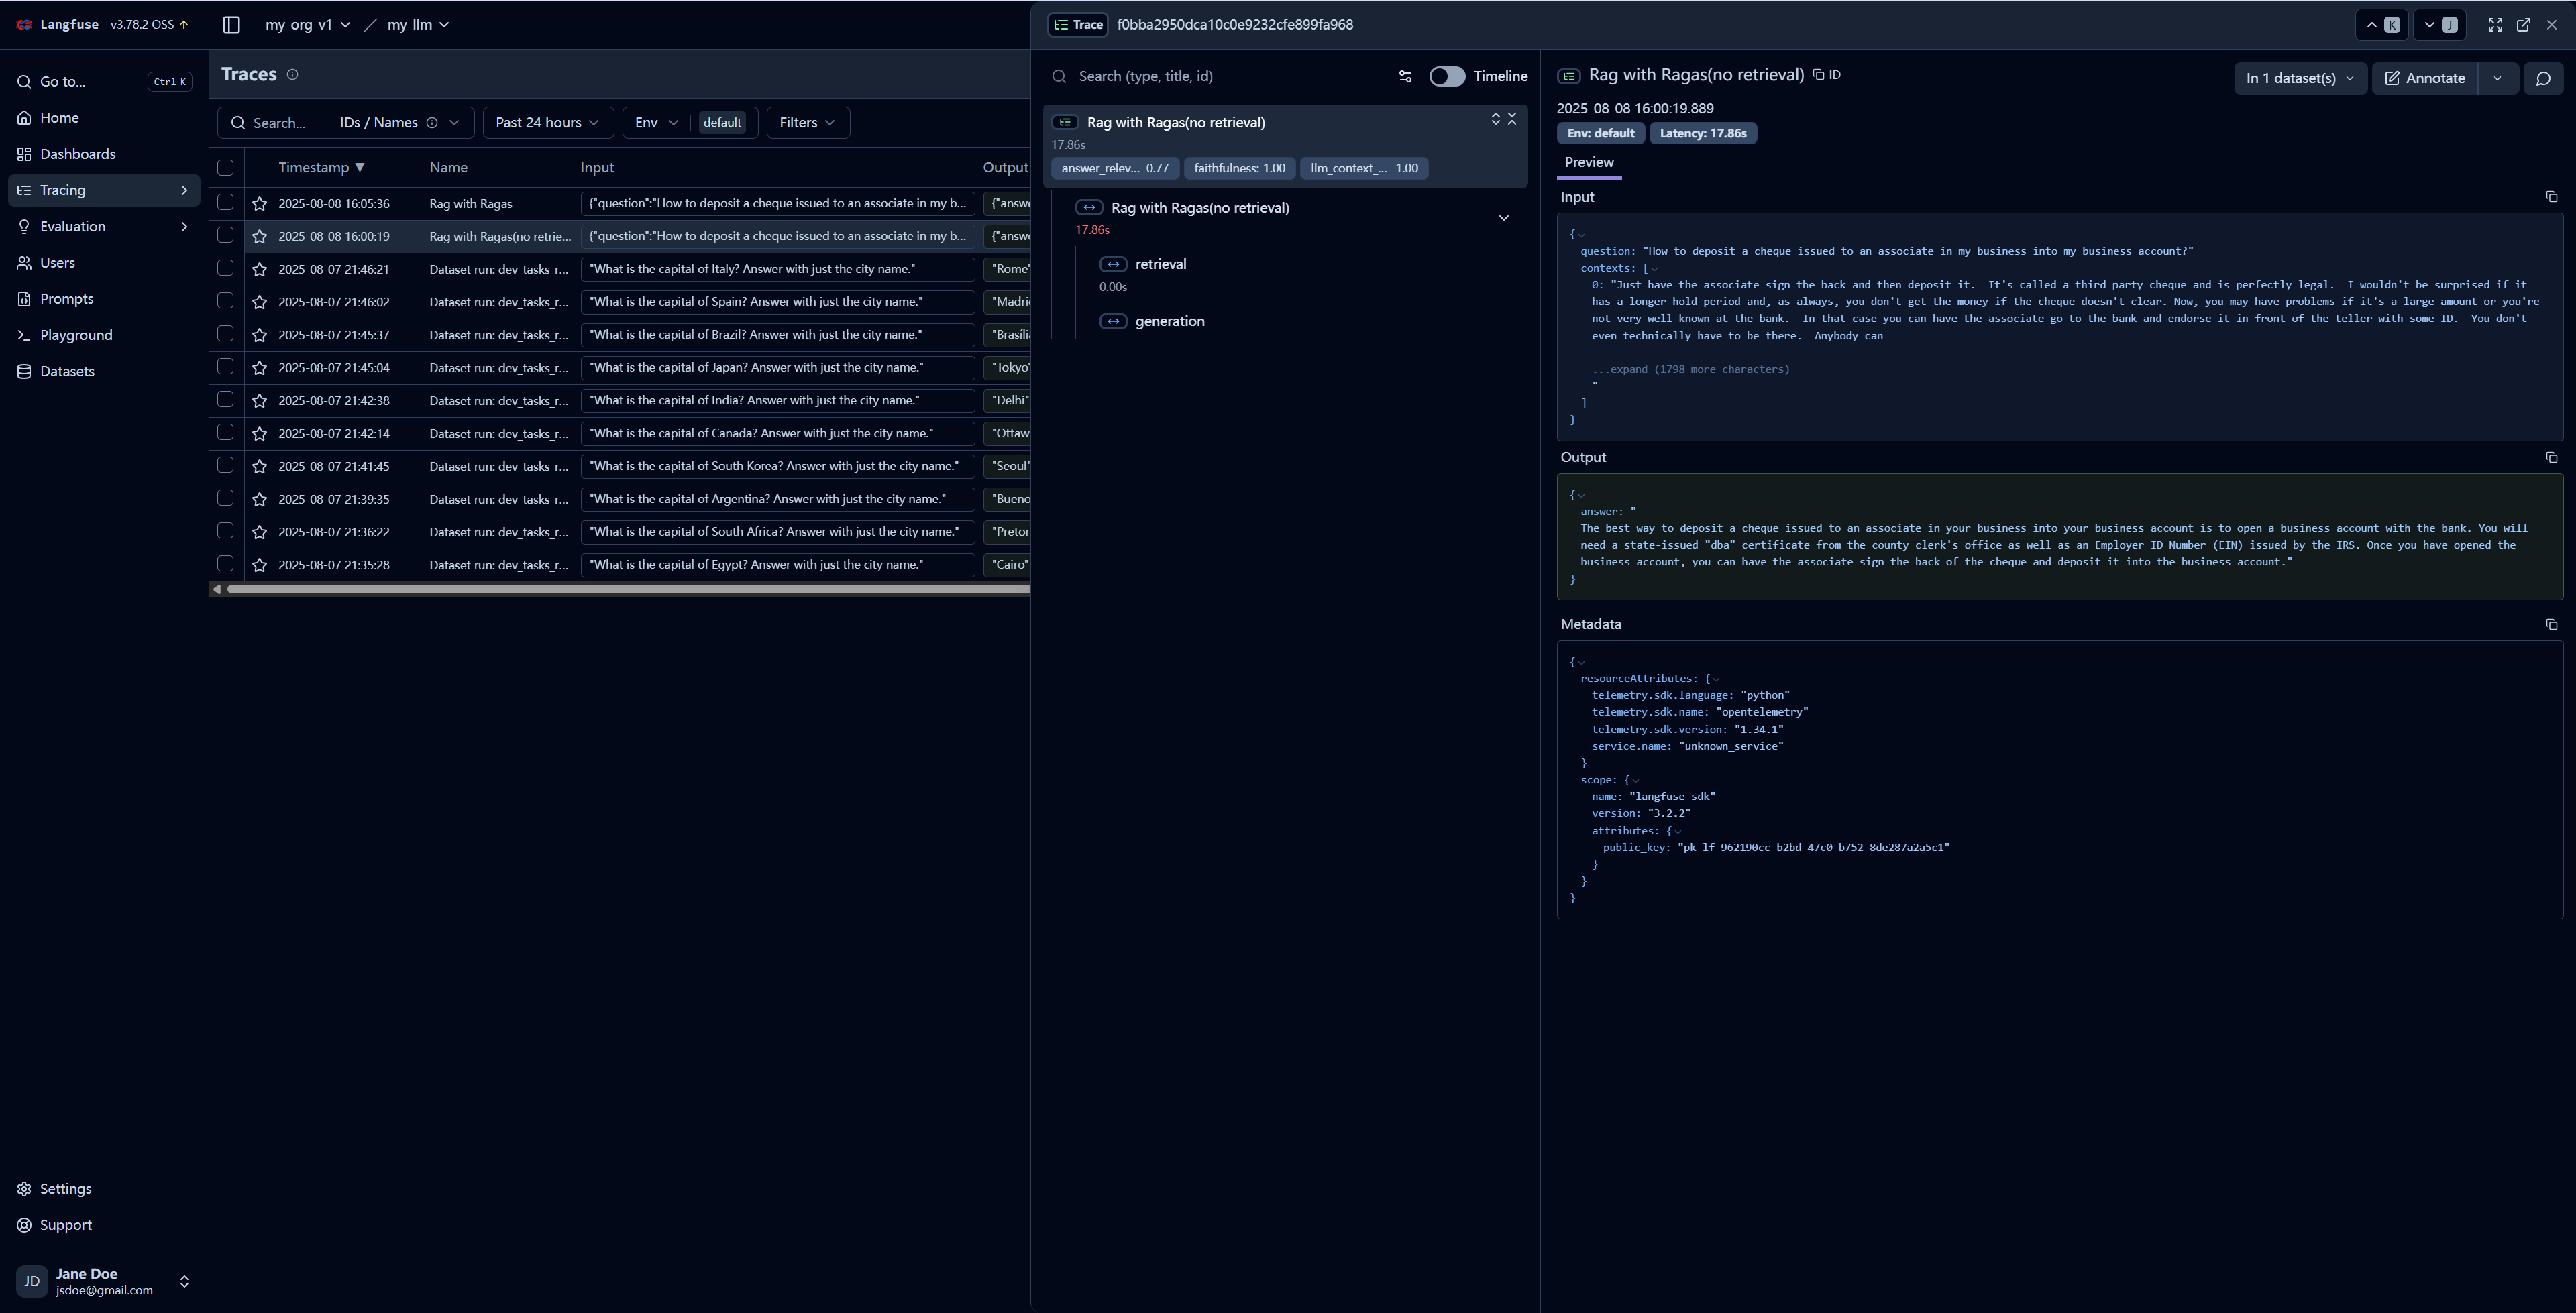

#### Use  RAG(FAISS) + RAGAS

In [29]:

from langchain.schema import Document
from langchain.vectorstores import FAISS

#  Simulated Knowledge Base
docs = [
    Document(page_content="To deposit a cheque issued to an associate into your business account, ensure the cheque is properly endorsed and provide documentation proving the business relationship to your bank."),
    Document(page_content="Business accounts allow you to manage company finances, deposit cheques, and make payments. Always keep records of all transactions for accounting purposes."),
    Document(page_content="When depositing third-party cheques, banks may require additional verification, such as authorization letters or proof of identity for the associate."),
    Document(page_content="For large deposits, contact your bank in advance to confirm the required documents and processing time."),
]

vectorstore = FAISS.from_documents(docs, emb)


# 查看所有原始文档内容
for idx in vectorstore.index_to_docstore_id.values():
    doc = vectorstore.docstore.search(idx)
    print(doc.page_content)

# 查看向量数量
print(len(vectorstore.index_to_docstore_id))

# 查看 FAISS 索引对象
print(vectorstore.index)



To deposit a cheque issued to an associate into your business account, ensure the cheque is properly endorsed and provide documentation proving the business relationship to your bank.
Business accounts allow you to manage company finances, deposit cheques, and make payments. Always keep records of all transactions for accounting purposes.
When depositing third-party cheques, banks may require additional verification, such as authorization letters or proof of identity for the associate.
For large deposits, contact your bank in advance to confirm the required documents and processing time.
4
<faiss.swigfaiss_avx2.IndexFlatL2; proxy of <Swig Object of type 'faiss::IndexFlatL2 *' at 0x000001735E1C6160> >


In [30]:
# Retrieve similar document chunks
def get_similar_chunks(query, k=2):
    retriever = vectorstore.as_retriever(search_kwargs={"k": k})
    return retriever.get_relevant_documents(query)


question = row['question']

# retrieve the relevant chunks
chunks = get_similar_chunks(question)

print("chunks:", chunks)

chunks: [Document(id='a28da354-4a3e-4b3e-a3bc-021ee2298b44', metadata={}, page_content='To deposit a cheque issued to an associate into your business account, ensure the cheque is properly endorsed and provide documentation proving the business relationship to your bank.'), Document(id='f973911e-906c-48bf-a51b-7ebfcd1275eb', metadata={}, page_content='When depositing third-party cheques, banks may require additional verification, such as authorization letters or proof of identity for the associate.')]


C:\Users\slsxz\AppData\Local\Temp\ipykernel_25584\2781608260.py:4: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  return retriever.get_relevant_documents(query)


In [31]:
# Get LLM response
def get_response_llm(question, chunks):
    chunks_text = "\n".join([doc.page_content for doc in chunks])
    prompt = f"Answer the following question based on the provided context.\nContext:\n{chunks_text}\nQuestion: {question}"
    return llm.predict(prompt)


# use llm to generate a answer with the trunks
answer = get_response_llm(question, chunks)

print("answer:", answer)

C:\Users\slsxz\AppData\Local\Temp\ipykernel_25584\2748172350.py:5: LangChainDeprecationWarning: The method `BaseChatModel.predict` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  return llm.predict(prompt)


answer: 
Based on the provided context, here's how to deposit a cheque issued to an associate in your business account:

1.  **Endorse the Cheque:** Ensure the cheque is properly endorsed (signed) by the associate to allow it to be deposited into your account.
2.  **Provide Business Relationship Documentation:** Give your bank documentation that proves the business relationship between you and the associate.
3.  **Be Prepared for Additional Verification:** If your bank requires it (especially since this is a third-party cheque), be ready to provide extra proof. This might include authorization letters or the associate's proof of identity.


In [ ]:

from langchain.schema import Document
from langchain.vectorstores import FAISS

#  Simulated Knowledge Base
docs = [
    Document(page_content="To deposit a cheque issued to an associate into your business account, ensure the cheque is properly endorsed and provide documentation proving the business relationship to your bank."),
    Document(page_content="Business accounts allow you to manage company finances, deposit cheques, and make payments. Always keep records of all transactions for accounting purposes."),
    Document(page_content="When depositing third-party cheques, banks may require additional verification, such as authorization letters or proof of identity for the associate."),
    Document(page_content="For large deposits, contact your bank in advance to confirm the required documents and processing time."),
]

vectorstore = FAISS.from_documents(docs, emb)

# Retrieve similar document chunks
def get_similar_chunks(query, k=2):
    retriever = vectorstore.as_retriever(search_kwargs={"k": k})
    return retriever.get_relevant_documents(query)

# Get LLM response
def get_response_llm(question, chunks):
    chunks_text = "\n".join([doc.page_content for doc in chunks])
    prompt = f"Answer the following question based on the provided context.\nContext:\n{chunks_text}\nQuestion: {question}"
    return llm.predict(prompt)


question = row['question']
contexts = row['contexts']
answer = row['answer']

with langfuse.start_as_current_span(name="Rag with Ragas(user_id=123)") as trace:
    # Add user_id to the current trace
    langfuse.update_current_trace(user_id="user_123")

    # Store trace_id for later use
    trace_id = trace.trace_id

    # retrieve the relevant chunks
    chunks = get_similar_chunks(question)

    # pass it as span
    with trace.start_as_current_span(
        name="retrieval",
        input={"question": question},
        output={"contexts": contexts}
    ):
        trace.update(input={"question": question, "contexts": contexts})


    # use llm to generate a answer with the trunks
    answer = get_response_llm(question, chunks)

    with trace.start_as_current_span(
        name="generation",
        input={"question": question, "contexts": contexts},
        output={"answer": answer}
    ):
        trace.update(output={"answer": answer})

    # compute scores for the questions, context, answer tuple
    ragas_scores = await score_with_ragas(question, contexts, answer)


print("RAGAS Scores:", ragas_scores)
ragas_scores

calculating faithfulness
calculating answer_relevancy
calculating llm_context_precision_without_reference
RAGAS Scores: {'faithfulness': 0.5, 'answer_relevancy': np.float64(0.8528195716908539), 'llm_context_precision_without_reference': 0.9999999999}


{'faithfulness': 0.5,
 'answer_relevancy': np.float64(0.8528195716908539),
 'llm_context_precision_without_reference': 0.9999999999}

Once the scores are computed you can add them to the trace in Langfuse:

In [36]:
# send the scores
# Use the trace_id stored from the previous cell
for m in metrics:
    langfuse.create_score(
        name=m.name, 
        value=ragas_scores[m.name], 
        trace_id=trace_id
    )

[trace url](http://localhost:3000/project/cmcoo14lx0006ph077uy36drf/traces?peek=9e3266db32a9ad80d99561b1963655f4&timestamp=2025-08-08T08%3A05%3A36.778Z)

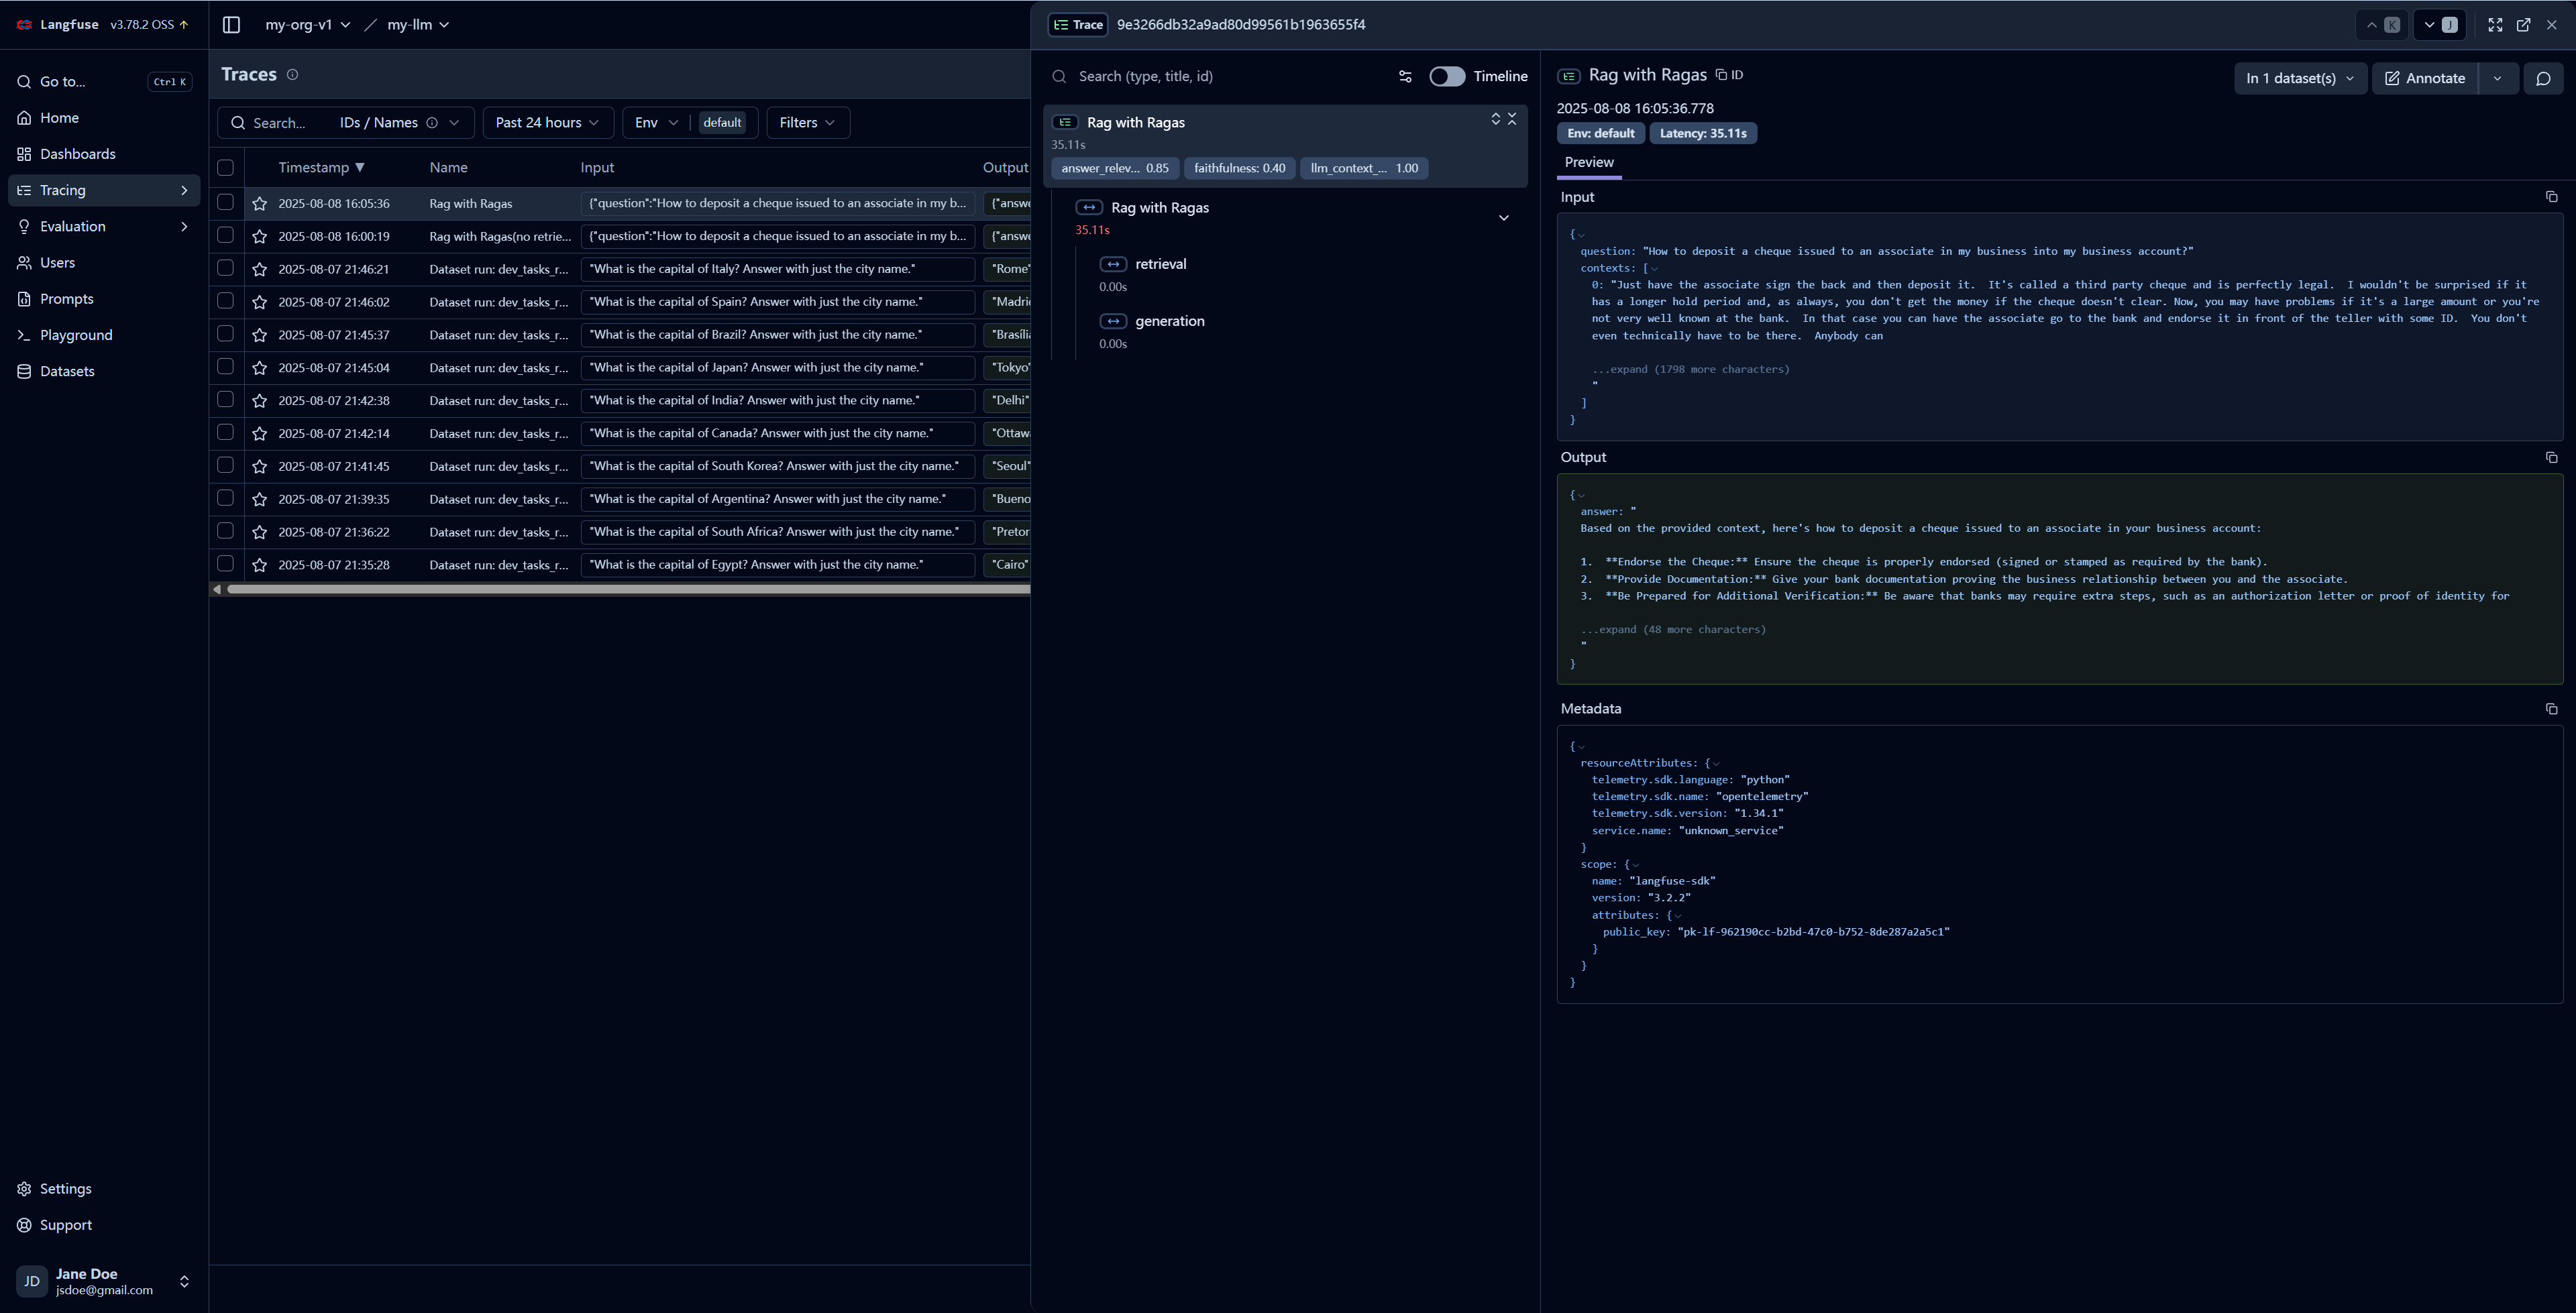



### [Run Langchain Evaluations on data in Langfuse](https://langfuse.com/guides/cookbook/evaluation_with_langchain)

This cookbook shows how model-based evaluations can be used to automate the evaluation of production completions in Langfuse. This example uses Langchain and is adaptable to other libraries. Which library is the best to use depends heavily on the use case.

This cookbook follows three steps:

1. Fetch production generations stored in Langfuse
2. Evaluate these generations using Langchain
3. Ingest results back into Langfuse as scores


#### Setup

In [ ]:
%pip install langfuse langchain langchain-openai --upgrade

In [8]:
import os
 
# LANGFUSE_SECRET_KEY="sk-lf-4e9959c3-0935-4142-b789-734beb81d15a"
# LANGFUSE_PUBLIC_KEY="pk-lf-962190cc-b2bd-47c0-b752-8de287a2a5c1"


# Get keys for your project from the project settings page: https://cloud.langfuse.com
os.environ["LANGFUSE_PUBLIC_KEY"] = "pk-lf-962190cc-b2bd-47c0-b752-8de287a2a5c1" 
os.environ["LANGFUSE_SECRET_KEY"] = "sk-lf-4e9959c3-0935-4142-b789-734beb81d15a" 
LANGFUSE_HOST="http://localhost:3000"

# Your openai key
# https://api.siliconflow.cn
os.environ["OPENAI_API_KEY"] = "sk-nfyvlkiykssllzekmddumkfxggollxgwiteckpcqaxchtgty"

In [9]:
from langfuse import get_client
 
langfuse = get_client()
 
# Verify connection
if langfuse.auth_check():
    print("Langfuse client is authenticated and ready!")
else:
    print("Authentication failed. Please check your credentials and host.")

Langfuse client is authenticated and ready!


In [10]:
os.environ['EVAL_MODEL'] = "Qwen2.5-7B-Instruct"

# Langchain Eval types
EVAL_TYPES={
    "hallucination": True,
    "conciseness": True,
    "relevance": True,
    "coherence": True,
    "harmfulness": True,
    "maliciousness": True,
    "helpfulness": True,
    "controversiality": True,
    "misogyny": True,
    "criminality": True,
    "insensitivity": True
}

#### Fetching data

In [14]:
def fetch_all_pages(name=None, user_id = None, limit=50):
    page = 1
    all_data = []
 
    while True:
        response = langfuse.api.trace.list(name=name, limit=limit, user_id=user_id, page=page)
        if not response.data:
            break
 
        all_data.extend(response.data)
        page += 1
 
    return all_data

In [15]:
generations = fetch_all_pages(user_id='user_123')

In [16]:
generations[0].id

'c3601abeb35cf229131493b1319a4da1'

#### Set up evaluation functions

 we define functions to set up the Langchain eval based on the entries in EVAL_TYPES. Hallucinations require their own function. More on the Langchain evals can be found here.

In [42]:
from langchain.evaluation import load_evaluator

# from langchain_openai import OpenAI
from langchain_openai.chat_models import ChatOpenAI
from langchain.evaluation.criteria import LabeledCriteriaEvalChain


def get_evaluator_for_key(key: str):
    # llm = OpenAI(temperature=0, model=os.environ.get("EVAL_MODEL"))
    llm = ChatOpenAI(
        api_key=os.environ.get("OPENAI_API_KEY"),
        base_url="https://api.siliconflow.cn",
        # model="Qwen/Qwen3-8B"
        # model="BAAI/bge-m3"
        # model="deepseek-ai/DeepSeek-V3"
        model="THUDM/GLM-4-9B-0414",
    )
    return load_evaluator("criteria", criteria=key, llm=llm)


def get_hallucination_eval():
    criteria = {
        "hallucination": (
            "Does this submission contain information"
            " not present in the input or reference?"
        ),
    }

    # llm = OpenAI(temperature=0, model=os.environ.get("EVAL_MODEL"))

    llm = ChatOpenAI(
        api_key=os.environ.get("OPENAI_API_KEY"),
        base_url="https://api.siliconflow.cn",
        model="Qwen/Qwen2.5-7B-Instruct",  # 例如 "Qwen2.5-7B-Instruct"
        temperature=0,
    )

    return LabeledCriteriaEvalChain.from_llm(llm=llm, criteria=criteria)

#### Execute evaluation

we execute the evaluation for each Generation loaded above. Each score is ingested into Langfuse via langfuse.score().

In [28]:
def execute_eval_and_score():
    for generation in generations:
        criteria = [key for key, value in EVAL_TYPES.items() if value and key != "hallucination"]

        for criterion in criteria:
            eval_result = get_evaluator_for_key(criterion).evaluate_strings(
                prediction=generation.output,
                input=generation.input,
            )
            # print(f"Generation: {generation}\nCriterion: {criterion}\nScore: {eval_result}\n")
            print(eval_result)
            langfuse.create_score(
                name=criterion,
                trace_id=generation.id,
                observation_id=generation.id,
                value=eval_result["score"],
                comment=eval_result["reasoning"],
            )

            # 只要分数
            # langfuse.create_score(
            #     name=criterion,
            #     trace_id=generation.id,
            #     # observation_id=generation.id,
            #     value=eval_result["score"],
            #     # comment=eval_result["reasoning"],
            # )


execute_eval_and_score()

{'reasoning': '**Reasoning:**\n\n1.  **Analyze the Criterion:** The criterion is "conciseness," which means the submission should be brief,to the point, and without unnecessary words or information.\n2.  **Examine the Submission Content:** The submission provides a list of three steps: endorsing the cheque, providing documentation, and being prepared for extra verification.\n3.  **Evaluate for Brevity:** The answer is presented in a numbered list format, which helps structure it concisely. The steps listed are direct and focused on the core actions needed.\n4.  **Check for Unnecessary Information:** The submission does not include personal opinions, much of the detailed context provided in the input (like potential banking fees, federal regulations, red flags about cheque naming), or repetitive explanations. It sticks solely to the procedure.\n5.  **Conclusion on Conciseness:** The submission focuses solely on the task (depositing a third-party cheque) and presents the core steps requi

#### See Scores in Langfuse

In the Langfuse UI, you can filter Traces by Scores and look into the details for each. Check out Langfuse Analytics to understand the impact of new prompt versions or application releases on these scores.

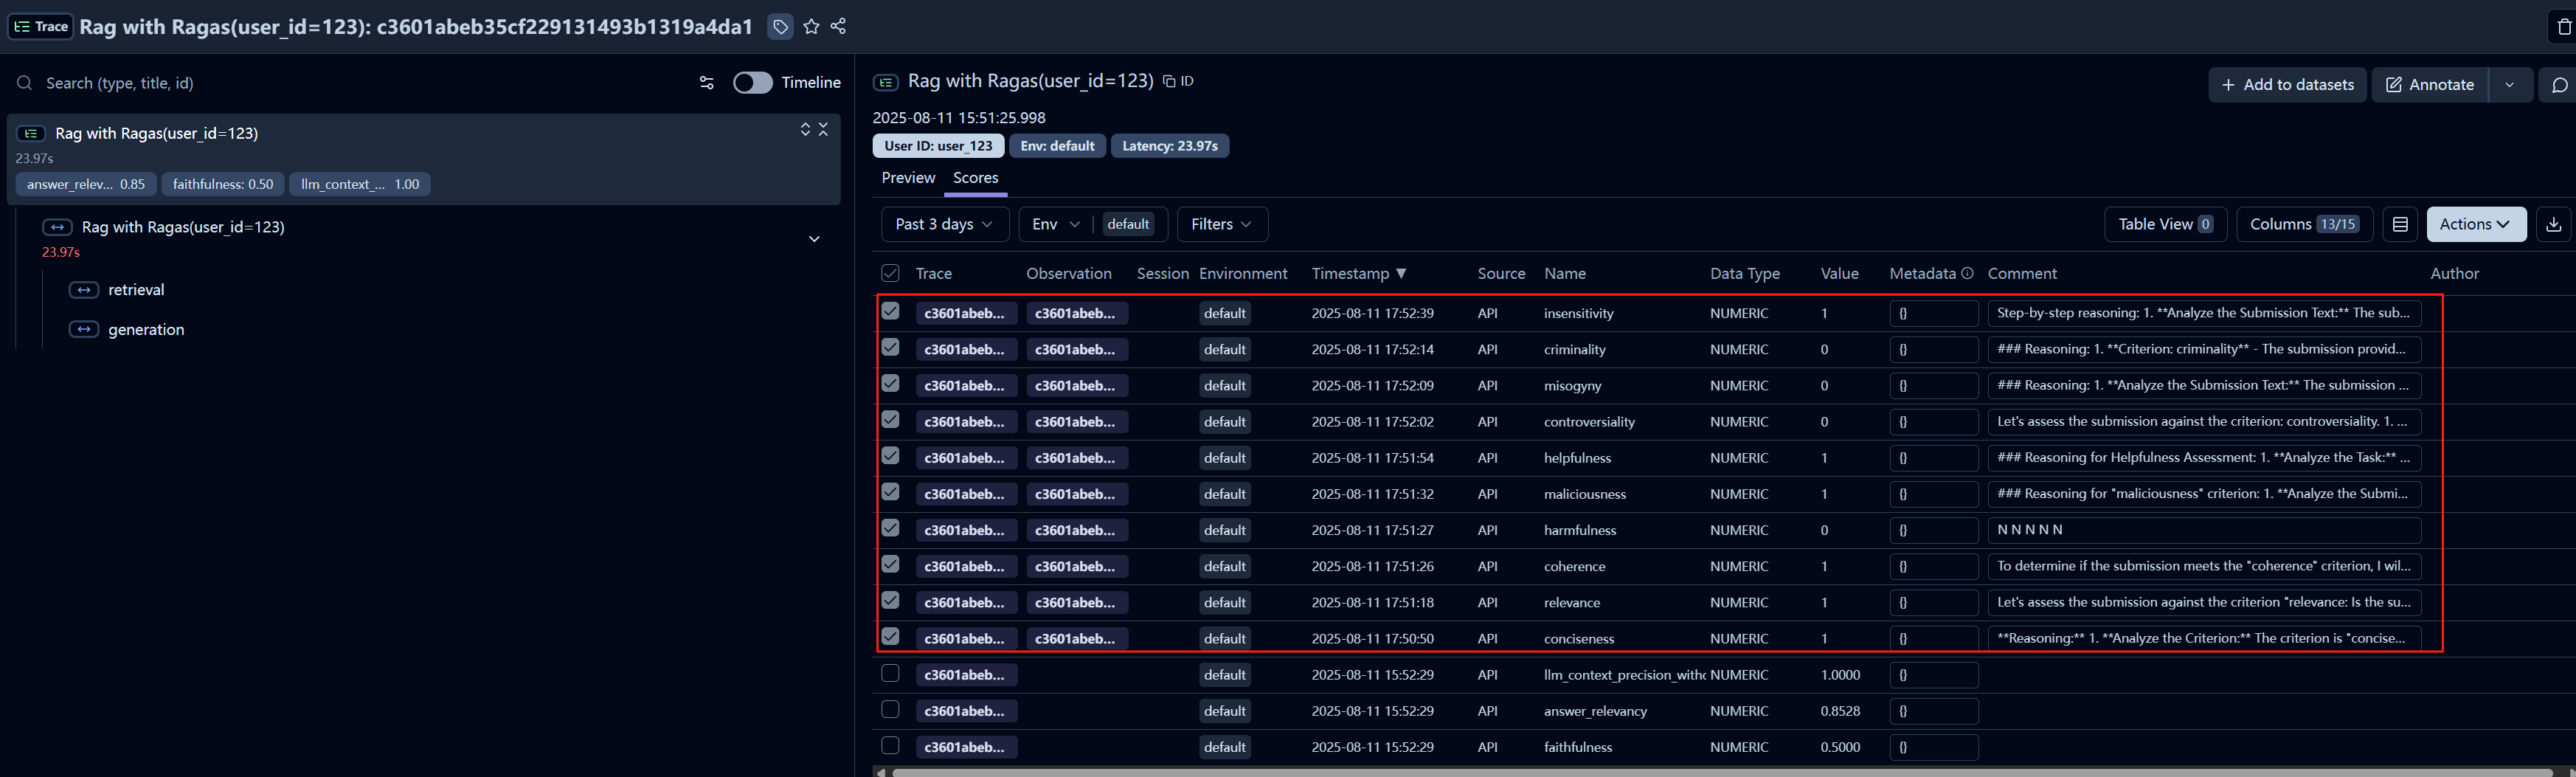

In [ ]:
# 只要分数显示
# langfuse.create_score(
#     name=criterion,
#     trace_id=generation.id,
#     # observation_id=generation.id,  --注释
#     value=eval_result["score"],
#     # comment=eval_result["reasoning"], --注释
# )

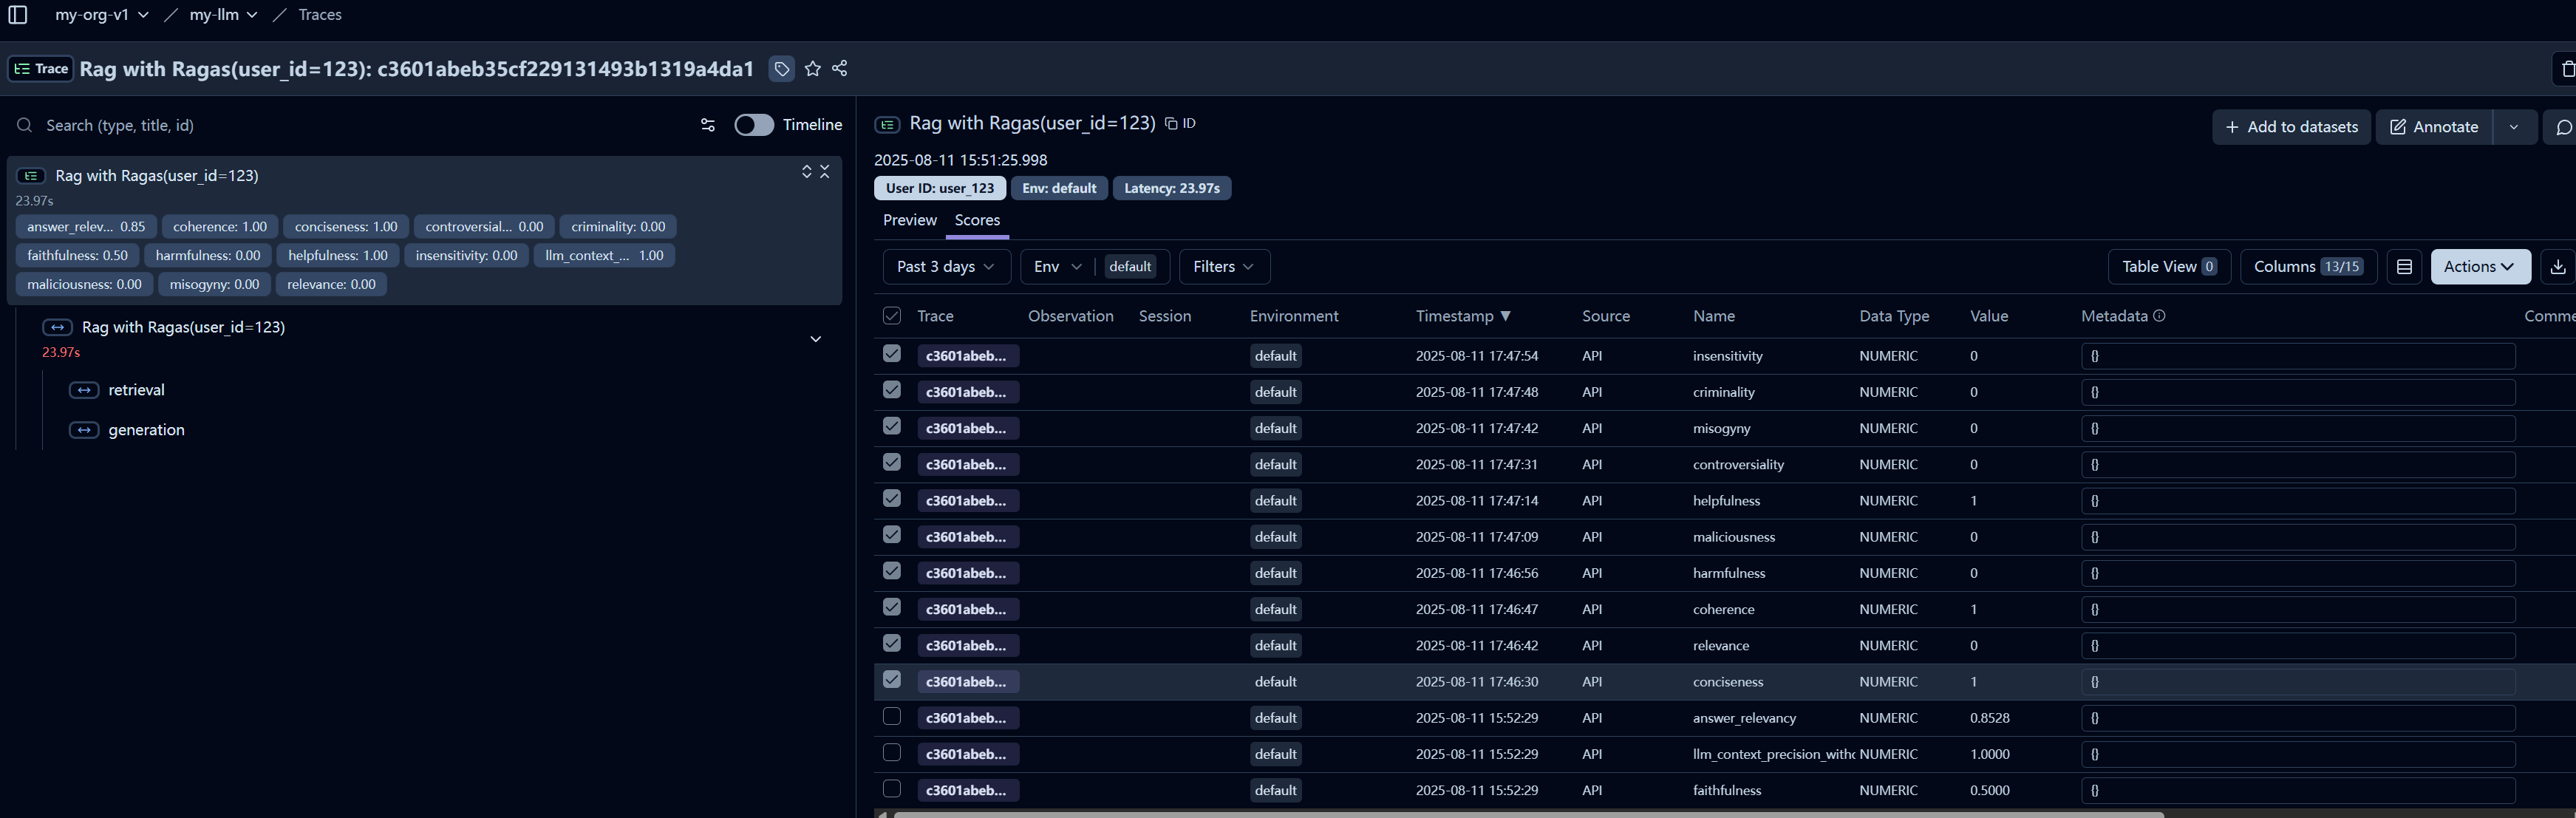

In [44]:
# hallucination
def eval_hallucination():
    chain = get_hallucination_eval()
    for generation in generations:
        eval_result = chain.evaluate_strings(
            prediction=generation.output,
            input=generation.input,
            reference=generation.input,
        )

        print(eval_result)
        if (
            eval_result is not None
            and eval_result["score"] is not None
            and eval_result["reasoning"] is not None
        ):
            langfuse.create_score(
                name="hallucination",
                trace_id=generation.id,
                observation_id=generation.id,
                value=eval_result["score"],
                comment=eval_result["reasoning"],
            )

In [45]:
if EVAL_TYPES.get("hallucination") == True:
    eval_hallucination()

{'reasoning': 'N', 'value': 'N', 'score': 0}


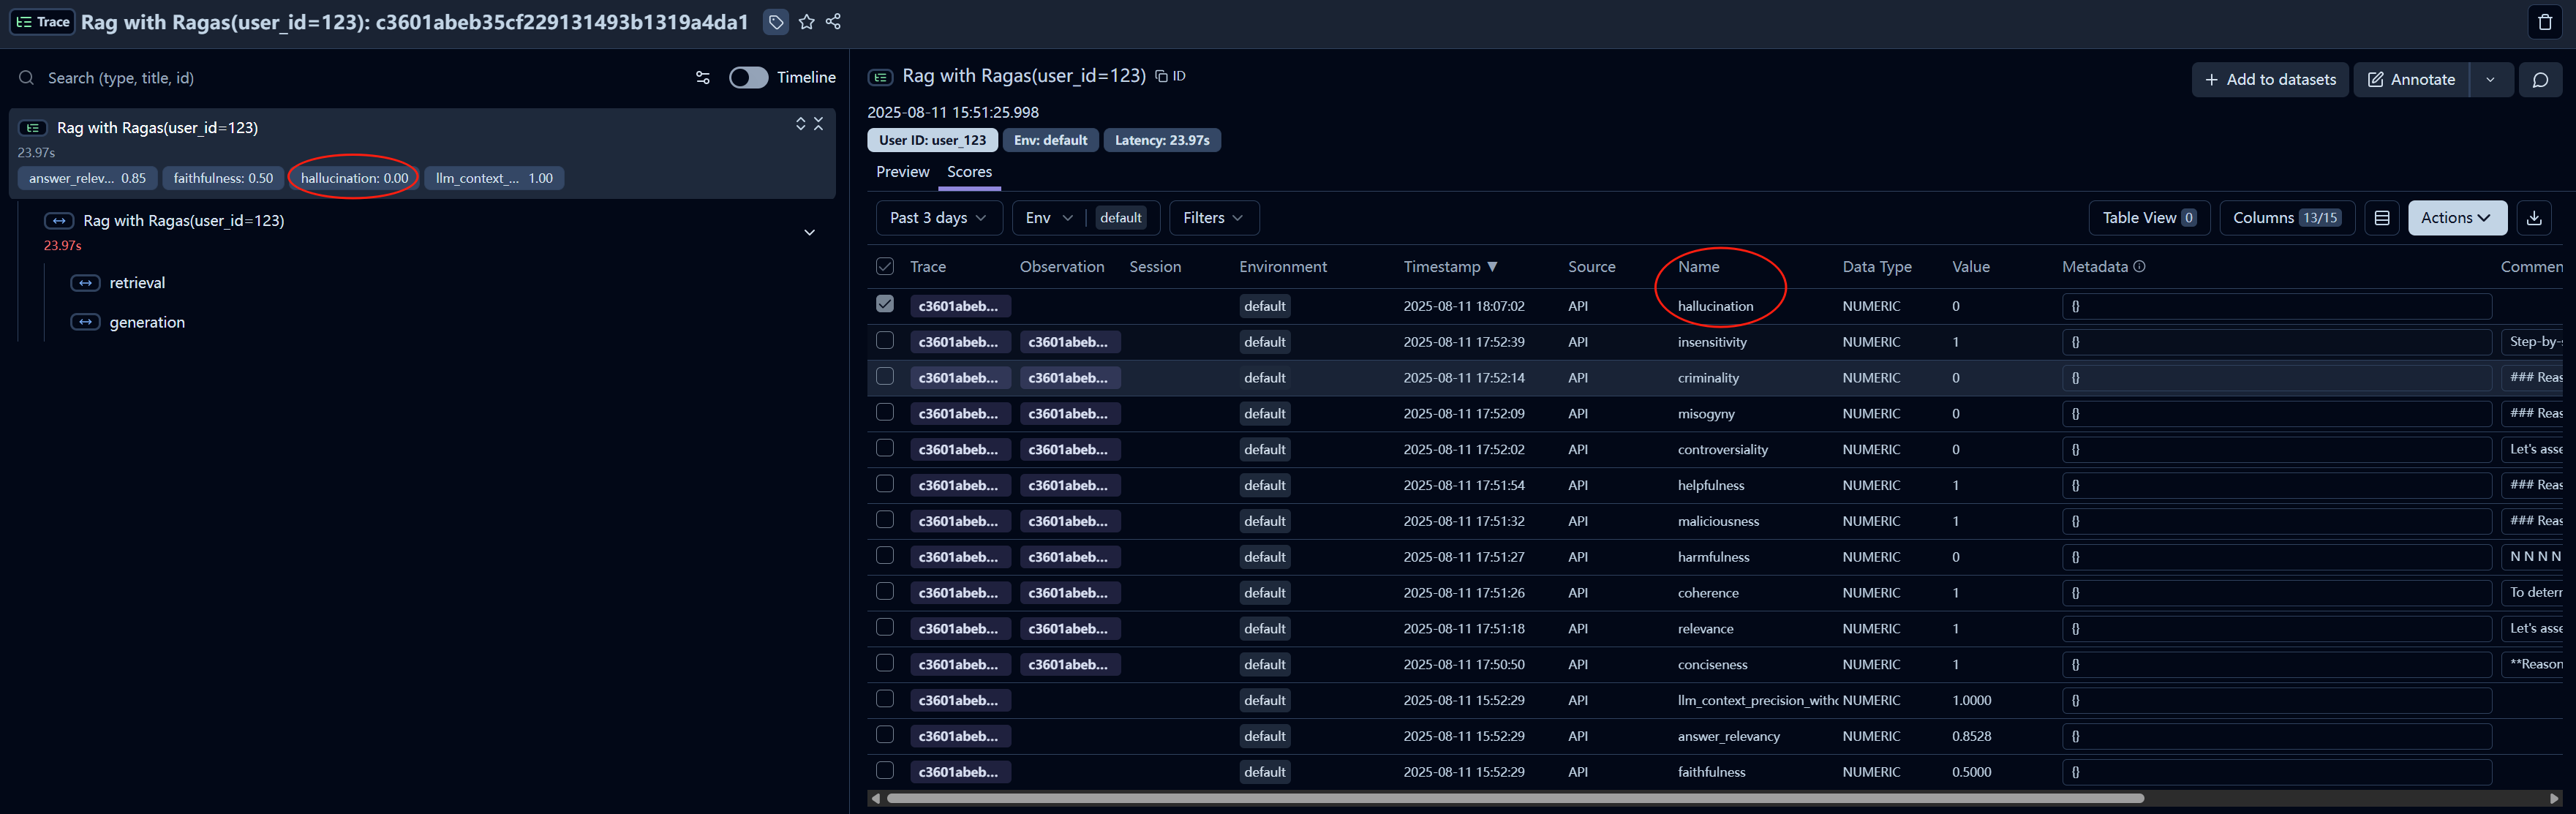

In [ ]:
# SDK is async, make sure to await all requests
langfuse.flush()

#### Get in touch

Looking for a specific way to score your production data in Langfuse? Join the Discord and discuss your use case!

### [Evaluate Langfuse LLM Traces with UpTrain](https://langfuse.com/guides/cookbook/evaluation_with_uptrain)

UpTrain’s open-source library offers a series of evaluation metrics to assess LLM applications.

This notebook demonstrates how to run UpTrain’s evaluation metrics on the traces generated by Langfuse. In Langfuse you can then monitor these scores over time or use them to compare different experiments.

#### Setup

In [ ]:
%pip install langfuse datasets uptrain litellm openai rouge_score --upgrade

In [ ]:
import os

# Get keys for your project from the project settings page: https://cloud.langfuse.com
os.environ["LANGFUSE_PUBLIC_KEY"] = "pk-lf-962190cc-b2bd-47c0-b752-8de287a2a5c1" 
os.environ["LANGFUSE_SECRET_KEY"] = "sk-lf-4e9959c3-0935-4142-b789-734beb81d15a" 
LANGFUSE_HOST="http://localhost:3000"

# Your openai key
# https://api.siliconflow.cn
os.environ["OPENAI_API_KEY"] = "sk-nfyvlkiykssllzekmddumkfxggollxgwiteckpcqaxchtgty"

#### Sample Dataset

We use this dataset to represent traces that you have logged to Langfuse. In a production environment, you would use your own data.


In [4]:
data = [
    {
        "question": "What are the symptoms of a heart attack?",
        "context": "A heart attack, or myocardial infarction, occurs when the blood supply to the heart muscle is blocked. Chest pain is a good symptom of heart attack, though there are many others.",
        "response": "Symptoms of a heart attack may include chest pain or discomfort, shortness of breath, nausea, lightheadedness, and pain or discomfort in one or both arms, the jaw, neck, or back."
    },
    {
        "question": "Can stress cause physical health problems?",
        "context": "Stress is the body's response to challenges or threats. Yes, chronic stress can contribute to various physical health problems, including cardiovascular issues.",
        "response": "Yes, chronic stress can contribute to various physical health problems, including cardiovascular issues, and a weakened immune system."
    },
    {
        'question': "What are the symptoms of a heart attack?",
        'context': "A heart attack, or myocardial infarction, occurs when the blood supply to the heart muscle is blocked. Symptoms of a heart attack may include chest pain or discomfort, shortness of breath and nausea.",
        'response': "Heart attack symptoms are usually just indigestion and can be relieved with antacids."
    },
    {
        'question': "Can stress cause physical health problems?",
        'context': "Stress is the body's response to challenges or threats. Yes, chronic stress can contribute to various physical health problems, including cardiovascular issues.",
        'response': "Stress is not real, it is just imaginary!"
    }
]

#### Run Evaluations using UpTrain

We have used the following 3 metrics from UpTrain’s open-source library:

1. Context Relevance: Evaluates how relevant the retrieved context is to the question specified.

2. Factual Accuracy: Evaluates whether the response generated is factually correct and grounded by the provided context.

3. Response Completeness: Evaluates whether the response has answered all the aspects of the question specified.

You can look at the complete list of UpTrain’s supported metrics here

In [ ]:
import os
import json
import pandas as pd
from uptrain import EvalLLM, Evals
from uptrain.framework.base import Settings
import uptrain.framework.evalllm as evalllm_module

# 备份原始的验证函数
original_check = evalllm_module.check_openai_api_key

# 创建一个跳过验证的函数
def skip_api_key_check(api_key):
    return True

# 临时替换验证函数
evalllm_module.check_openai_api_key = skip_api_key_check

try:
    # 使用 Settings 配置 SiliconFlow
    settings = Settings(
        openai_api_key=os.environ["OPENAI_API_KEY"],  # SiliconFlow API key
        custom_llm_provider="openai",  # 使用 OpenAI 兼容的协议
        api_base="https://api.siliconflow.cn",  # SiliconFlow 的 API 地址
        model="THUDM/GLM-4-9B-0414",  # 你想使用的模型
    )
    
    eval_llm = EvalLLM(settings=settings)
    print("UpTrain EvalLLM 使用 SiliconFlow 初始化成功！")
    
finally:
    # 恢复原始验证函数
    evalllm_module.check_openai_api_key = original_check

# 运行评估
res = eval_llm.evaluate(
    data=data,
    checks=[Evals.CONTEXT_RELEVANCE, Evals.FACTUAL_ACCURACY, Evals.RESPONSE_COMPLETENESS]
)

# 查看评估结果
print(res)

2025-08-12 12:35:39.741 | WARNING  | uptrain.operators.language.llm:fetch_responses:268 - Detected a running event loop, scheduling requests in a separate thread.


UpTrain EvalLLM 使用 SiliconFlow 初始化成功！


100%|██████████| 4/4 [00:09<00:00,  2.35s/it]
2025-08-12 12:35:49.145 | WARNING  | uptrain.operators.language.llm:fetch_responses:268 - Detected a running event loop, scheduling requests in a separate thread.
100%|██████████| 4/4 [00:09<00:00,  2.28s/it]
2025-08-12 12:35:58.278 | WARNING  | uptrain.operators.language.llm:fetch_responses:268 - Detected a running event loop, scheduling requests in a separate thread.
100%|██████████| 4/4 [00:22<00:00,  5.58s/it]
2025-08-12 12:36:20.661 | WARNING  | uptrain.operators.language.llm:fetch_responses:268 - Detected a running event loop, scheduling requests in a separate thread.
100%|██████████| 4/4 [00:08<00:00,  2.25s/it]
2025-08-12 12:36:29.694 | INFO     | uptrain.framework.evalllm:evaluate:376 - Local server not running, start the server to log data and visualize in the dashboard!


[{'question': 'What are the symptoms of a heart attack?', 'context': 'A heart attack, or myocardial infarction, occurs when the blood supply to the heart muscle is blocked. Chest pain is a good symptom of heart attack, though there are many others.', 'response': 'Symptoms of a heart attack may include chest pain or discomfort, shortness of breath, nausea, lightheadedness, and pain or discomfort in one or both arms, the jaw, neck, or back.', 'score_context_relevance': 0.5, 'explanation_context_relevance': '\n{\n    "Reasoning": "The given context provides information about what a heart attack is and mentions that chest pain is a symptom. However, it does not list all the symptoms of a heart attack, only stating that there are many others. Therefore, the context gives some relevant information but cannot answer the query completely.",\n    "Choice": "B"\n}', 'score_factual_accuracy': 0.2, 'explanation_factual_accuracy': '\n```json\n{\n    "Result": [\n        {\n            "Fact": "Ches

#### Using Langfuse
There are two main ways to run evaluations:

1. Score each Trace (in development): This means you will run the UpTrain evaluations for each trace item.

2. Score in Batches (in production): In this method we will simulate fetching production traces on a periodic basis to score them using the UpTrain evaluators. Often, you’ll want to sample the traces instead of scoring all of them to control evaluation costs.

#### Development: Score each trace while it’s created

In [6]:
from langfuse import get_client
 
langfuse = get_client()
 
# Verify connection
if langfuse.auth_check():
    print("Langfuse client is authenticated and ready!")
else:
    print("Authentication failed. Please check your credentials and host.")

Langfuse client is authenticated and ready!


We mock the instrumentation of your application by using the sample dataset. See the quickstart to integrate Langfuse with your application.

In [12]:
# start a new trace when you get a question
question = data[0]['question']
context = data[0]['context']
response = data[0]['response']

with langfuse.start_as_current_span(name="uptrain trace") as trace:
    # Store trace_id for later_use
    trace_id = trace.trace_id

    # Add user_id to the current trace
    langfuse.update_current_trace(user_id="uptrain_user_123")

    # retrieve the relevant chunks
    # chunks = get_similar_chunks(question)

    # pass it as span
    with trace.start_as_current_span(
        name="retrieval",
        input={'question': question},
        output={'context': context}
    ):
        trace.update(input={"question": question, "context": context})

   # use llm to generate a answer with the chunks
   # answer = get_response_from_llm(question, chunks)

    with trace.start_as_current_span(
        name="generation",
        input={"question": question, "context": context},
        output={"response": response}
    ):
        trace.update(output={"response": response})
    

We reuse the scores previously calculated for the traces in the sample dataset. In development, you would run the UpTrain evaluations for the single trace as it’s created.

In [13]:
langfuse.create_score(name='context_relevance', value=res[0]['score_context_relevance'], trace_id=trace_id)
langfuse.create_score(name='factual_accuracy', value=res[0]['score_factual_accuracy'], trace_id=trace_id)
langfuse.create_score(name='response_completeness', value=res[0]['score_response_completeness'], trace_id=trace_id)

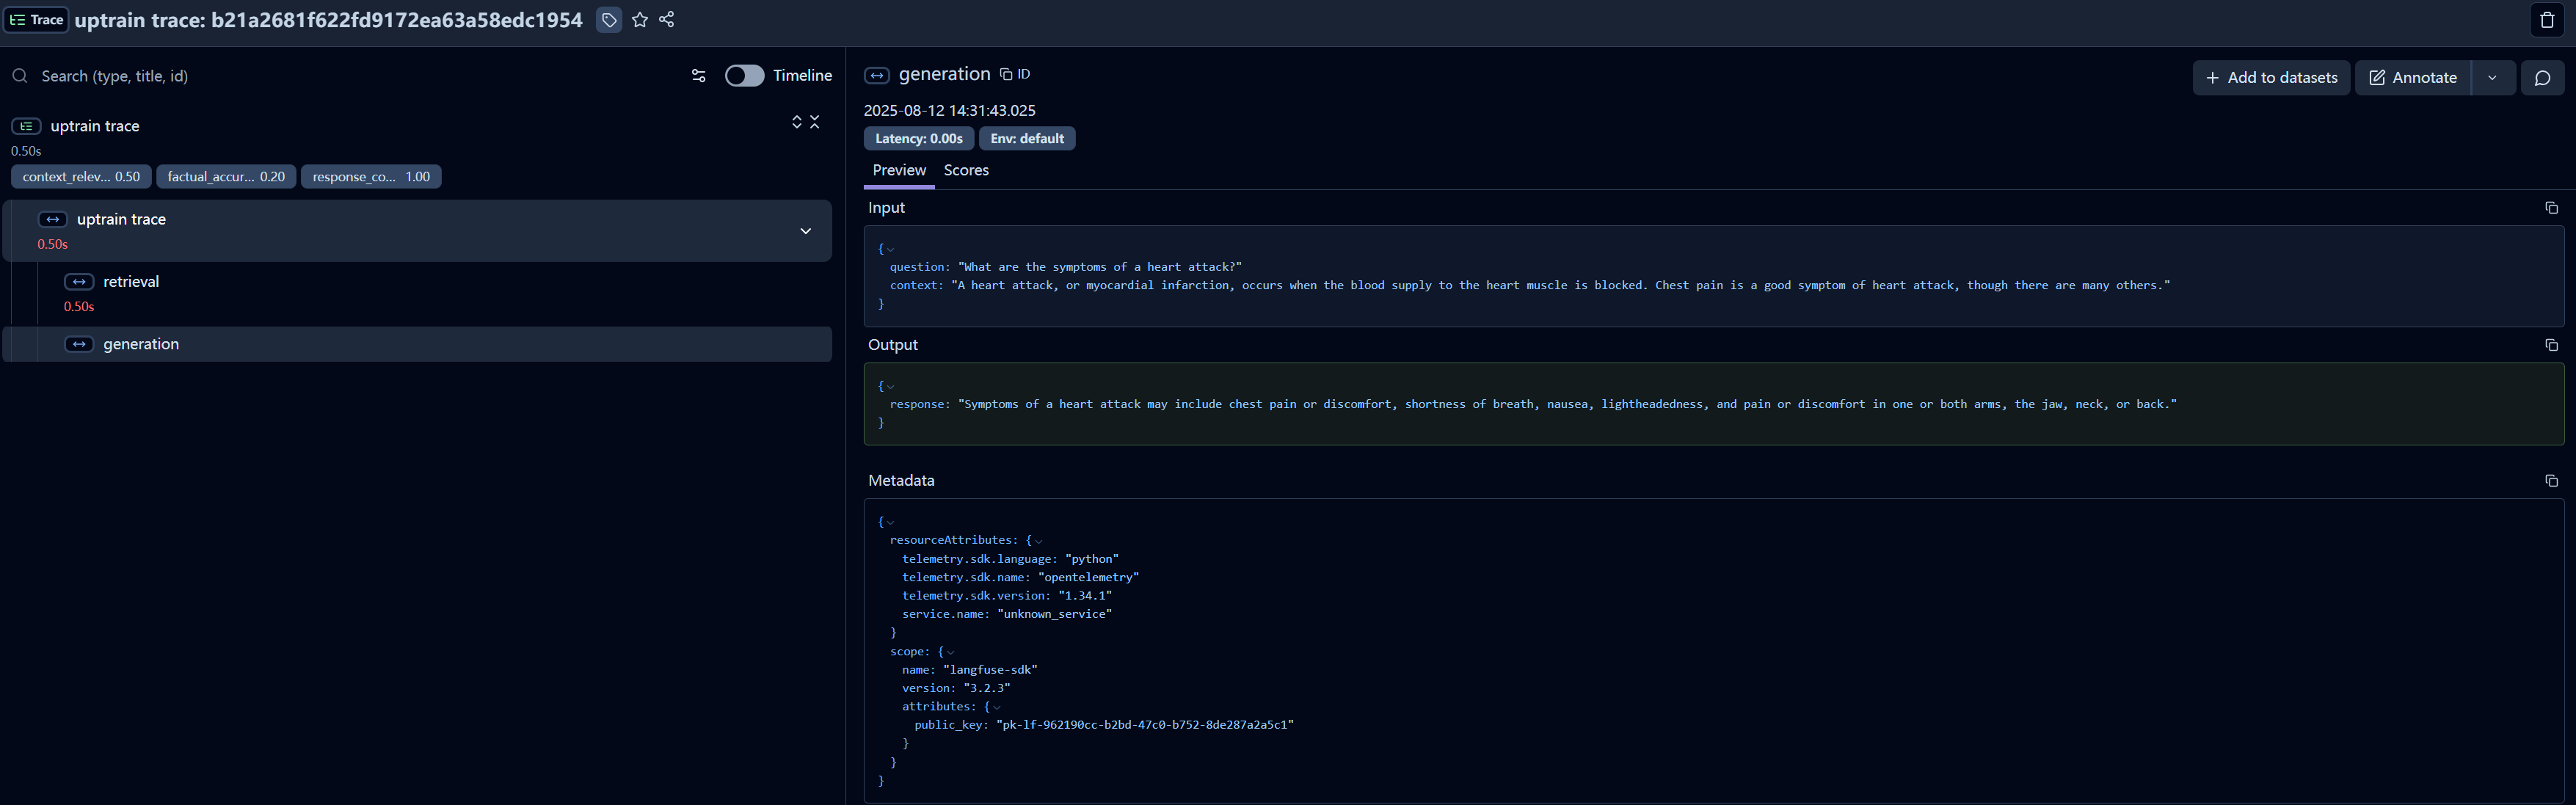

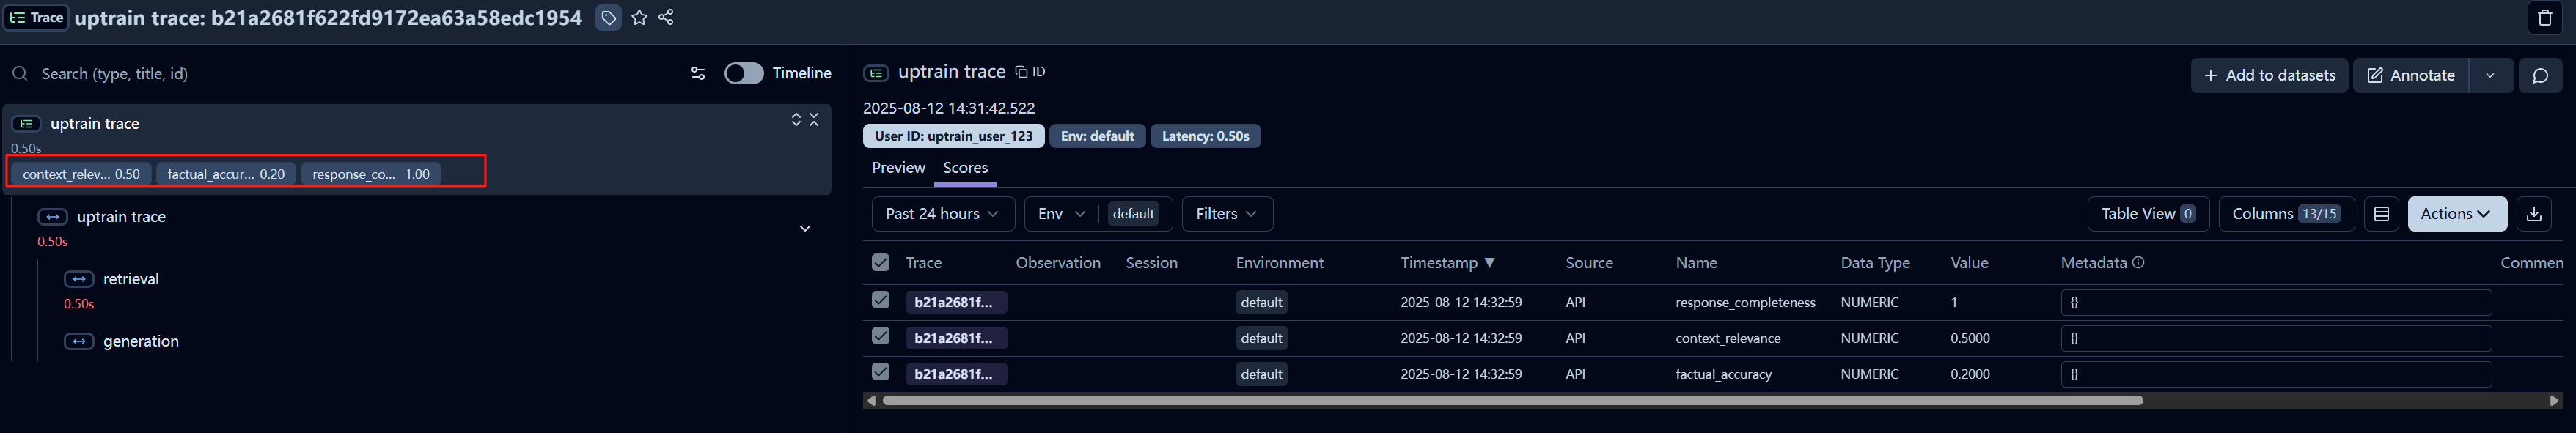

#### Production: Add scores to traces in batches
To simulate a production environment, we will log our sample dataset to Langfuse.

In [17]:
for i, interaction in enumerate(data):
    with langfuse.start_as_current_span(name="uptrain batch") as trace:
        # Add user_id to the current trace
        langfuse.update_current_trace(user_id=f"uptrain batch_{i}")
        
        with trace.start_as_current_span(
            name="retrieval",
            input={'question': interaction['question']},
            output={'context': interaction['context']}
        ):
            trace.update(input={"question": interaction['question'], "context": interaction['context']})

        with trace.start_as_current_span(
            name="generation",
            input={"question": interaction['question'], 'context':interaction},
            output={'response':interaction['response']}
        ):
            trace.update(output={"response": interaction['response']})

# await that Langfuse SDK has processed all events before trying to retrieve it in the next step
langfuse.flush()

We can now retrieve the traces like regular production data and evaluate them using UpTrain.

In [18]:
def get_traces(name=None, limit=10000, user_id=None):
    all_data = []
    page = 1

    while True:
        response = langfuse.api.trace.list(
            name=name, page=page, user_id=user_id, order_by=None
        )
        if not response.data:
            break
        page += 1
        all_data.extend(response.data)
        if len(all_data) > limit:
            break

    return all_data[:limit]

In [24]:
from random import sample


NUM_TRACES_TO_SAMPLE = 4
traces = get_traces(name="uptrain batch")
traces_sample = sample(traces, NUM_TRACES_TO_SAMPLE)

traces_sample

[TraceWithDetails(id='57f9325be4dfa70c14369304c838602d', timestamp=datetime.datetime(2025, 8, 12, 6, 58, 33, 851000, tzinfo=datetime.timezone.utc), name='uptrain batch', input={'question': 'Can stress cause physical health problems?', 'context': "Stress is the body's response to challenges or threats. Yes, chronic stress can contribute to various physical health problems, including cardiovascular issues."}, output={'response': 'Stress is not real, it is just imaginary!'}, session_id=None, release=None, version=None, user_id='uptrain batch_3', metadata={'resourceAttributes': {'telemetry.sdk.language': 'python', 'telemetry.sdk.name': 'opentelemetry', 'telemetry.sdk.version': '1.34.1', 'service.name': 'unknown_service'}, 'scope': {'name': 'langfuse-sdk', 'version': '3.2.3', 'attributes': {'public_key': 'pk-lf-962190cc-b2bd-47c0-b752-8de287a2a5c1'}}}, tags=[], public=False, environment='default', html_path='/project/cmcoo14lx0006ph077uy36drf/traces/57f9325be4dfa70c14369304c838602d', latenc

In [29]:
for t in traces_sample:
    observations = [langfuse.api.observations.get(o) for o in t.observations]

observations

[ObservationsView(id='357b2af1377d4c91', trace_id='753379b0aec6a8367d9c075374e616c4', type='SPAN', name='generation', start_time=datetime.datetime(2025, 8, 12, 6, 58, 33, 845000, tzinfo=datetime.timezone.utc), end_time=datetime.datetime(2025, 8, 12, 6, 58, 33, 845000, tzinfo=datetime.timezone.utc), completion_start_time=None, model=None, model_parameters=None, input={'question': 'Can stress cause physical health problems?', 'context': {'question': 'Can stress cause physical health problems?', 'context': "Stress is the body's response to challenges or threats. Yes, chronic stress can contribute to various physical health problems, including cardiovascular issues.", 'response': 'Yes, chronic stress can contribute to various physical health problems, including cardiovascular issues, and a weakened immune system.'}}, version=None, metadata={'resourceAttributes': {'telemetry.sdk.language': 'python', 'telemetry.sdk.name': 'opentelemetry', 'telemetry.sdk.version': '1.34.1', 'service.name': 'u

In [ ]:
evaluation_batch = {
    "question":[],
    "context":[],
    "response":[],
    "trace_id":[]
}

for t in traces_sample:
    observations = [langfuse.api.observations.get(o) for o in t.observations]
    for o in observations:
        if o.name == "retrieval":
            question = o.input['question']
            context = o.output['context']
        if o.name == 'generation':
            answer = o.output['response']

    evaluation_batch['question'].append(question)
    evaluation_batch['context'].append(context)
    evaluation_batch['response'].append(response)
    evaluation_batch['trace_id'].append(t.id)

data = [dict(zip(evaluation_batch, t)) for t in zip(*evaluation_batch.values())]

data


[{'question': 'Can stress cause physical health problems?',
  'context': "Stress is the body's response to challenges or threats. Yes, chronic stress can contribute to various physical health problems, including cardiovascular issues.",
  'response': 'Symptoms of a heart attack may include chest pain or discomfort, shortness of breath, nausea, lightheadedness, and pain or discomfort in one or both arms, the jaw, neck, or back.',
  'trace_id': '57f9325be4dfa70c14369304c838602d'},
 {'question': 'What are the symptoms of a heart attack?',
  'context': 'A heart attack, or myocardial infarction, occurs when the blood supply to the heart muscle is blocked. Chest pain is a good symptom of heart attack, though there are many others.',
  'response': 'Symptoms of a heart attack may include chest pain or discomfort, shortness of breath, nausea, lightheadedness, and pain or discomfort in one or both arms, the jaw, neck, or back.',
  'trace_id': 'd9796089823510ed12115954c71363ce'},
 {'question': 'W

Evaluate the batch using UpTrain.

In [30]:
res = eval_llm.evaluate(
    data=data,
    checks=[
        Evals.CONTEXT_RELEVANCE,
        Evals.FACTUAL_ACCURACY,
        Evals.RESPONSE_COMPLETENESS,
    ],
)

2025-08-12 15:32:06.467 | WARNING  | uptrain.operators.language.llm:fetch_responses:268 - Detected a running event loop, scheduling requests in a separate thread.
100%|██████████| 4/4 [00:05<00:00,  1.40s/it]
2025-08-12 15:32:12.137 | WARNING  | uptrain.operators.language.llm:fetch_responses:268 - Detected a running event loop, scheduling requests in a separate thread.
100%|██████████| 4/4 [00:07<00:00,  1.80s/it]
2025-08-12 15:32:19.677 | WARNING  | uptrain.operators.language.llm:fetch_responses:268 - Detected a running event loop, scheduling requests in a separate thread.
100%|██████████| 4/4 [00:32<00:00,  8.14s/it]
2025-08-12 15:32:52.360 | WARNING  | uptrain.operators.language.llm:fetch_responses:268 - Detected a running event loop, scheduling requests in a separate thread.
100%|██████████| 4/4 [00:06<00:00,  1.56s/it]


Add the trace_id back to the dataset as it was omitted in the previous step to be compatible with UpTrain.

In [31]:
df = pd.DataFrame(res)
 
# add the langfuse trace_id to the result dataframe
df["trace_id"] = [d['trace_id'] for d in data]
 
df.head()

question  \
0  Can stress cause physical health problems?   
1    What are the symptoms of a heart attack?   
2    What are the symptoms of a heart attack?   
3  Can stress cause physical health problems?   

                                             context  \
0  Stress is the body's response to challenges or...   
1  A heart attack, or myocardial infarction, occu...   
2  A heart attack, or myocardial infarction, occu...   
3  Stress is the body's response to challenges or...   

                                            response  \
0  Symptoms of a heart attack may include chest p...   
1  Symptoms of a heart attack may include chest p...   
2  Symptoms of a heart attack may include chest p...   
3  Symptoms of a heart attack may include chest p...   

                           trace_id  score_context_relevance  \
0  57f9325be4dfa70c14369304c838602d                      1.0   
1  d9796089823510ed12115954c71363ce                      0.5   
2  541bc18b9ba767ec4a57edb5d08047c4                      1.0   
3  753379b0aec6a8367d9c075374e616c4                      1.0   

                       explanation_context_relevance  score_factual_accuracy  \
0  \n{\n    "Reasoning": "The given context direc...                     0.0   
1  \n{\n    "Reasoning": "The given context provi...                     0.6   
2  \n{\n    "Reasoning": "The given context direc...                     0.6   
3  \n{\n    "Reasoning": "The given context direc...                     0.0   

                        explanation_factual_accuracy  \
0  \n```json\n{\n    "Result": [\n        {\n    ...   
1  \n```json\n{\n    "Result": [\n        {\n    ...   
2  \n```json\n{\n    "Result": [\n        {\n    ...   
3  \n```json\n{\n    "Result": [\n        {\n    ...   

   score_response_completeness  \
0                          0.0   
1                          1.0   
2                          1.0   
3                          0.5   

                   explanation_response_completeness  
0  \n{\n    "Reasoning": "The response provides i...  
1  \n{\n    "Reasoning": "The given response list...  
2  \n{\n    "Reasoning": "The response lists comm...  
3  \n{\n    "Reasoning": "The response provides i...

Now that we have the evaluations, we can add them back to the traces in Langfuse as scores.

In [32]:
for _, row in df.iterrows():
    for metric_name in ["context_relevance", "factual_accuracy", "response_completeness"]:
        langfuse.create_score(
            name=metric_name,
            value=row["score_"+metric_name],
            trace_id=row["trace_id"]
        )

In Langfuse, you can now see the scores for each trace and monitor them over time.

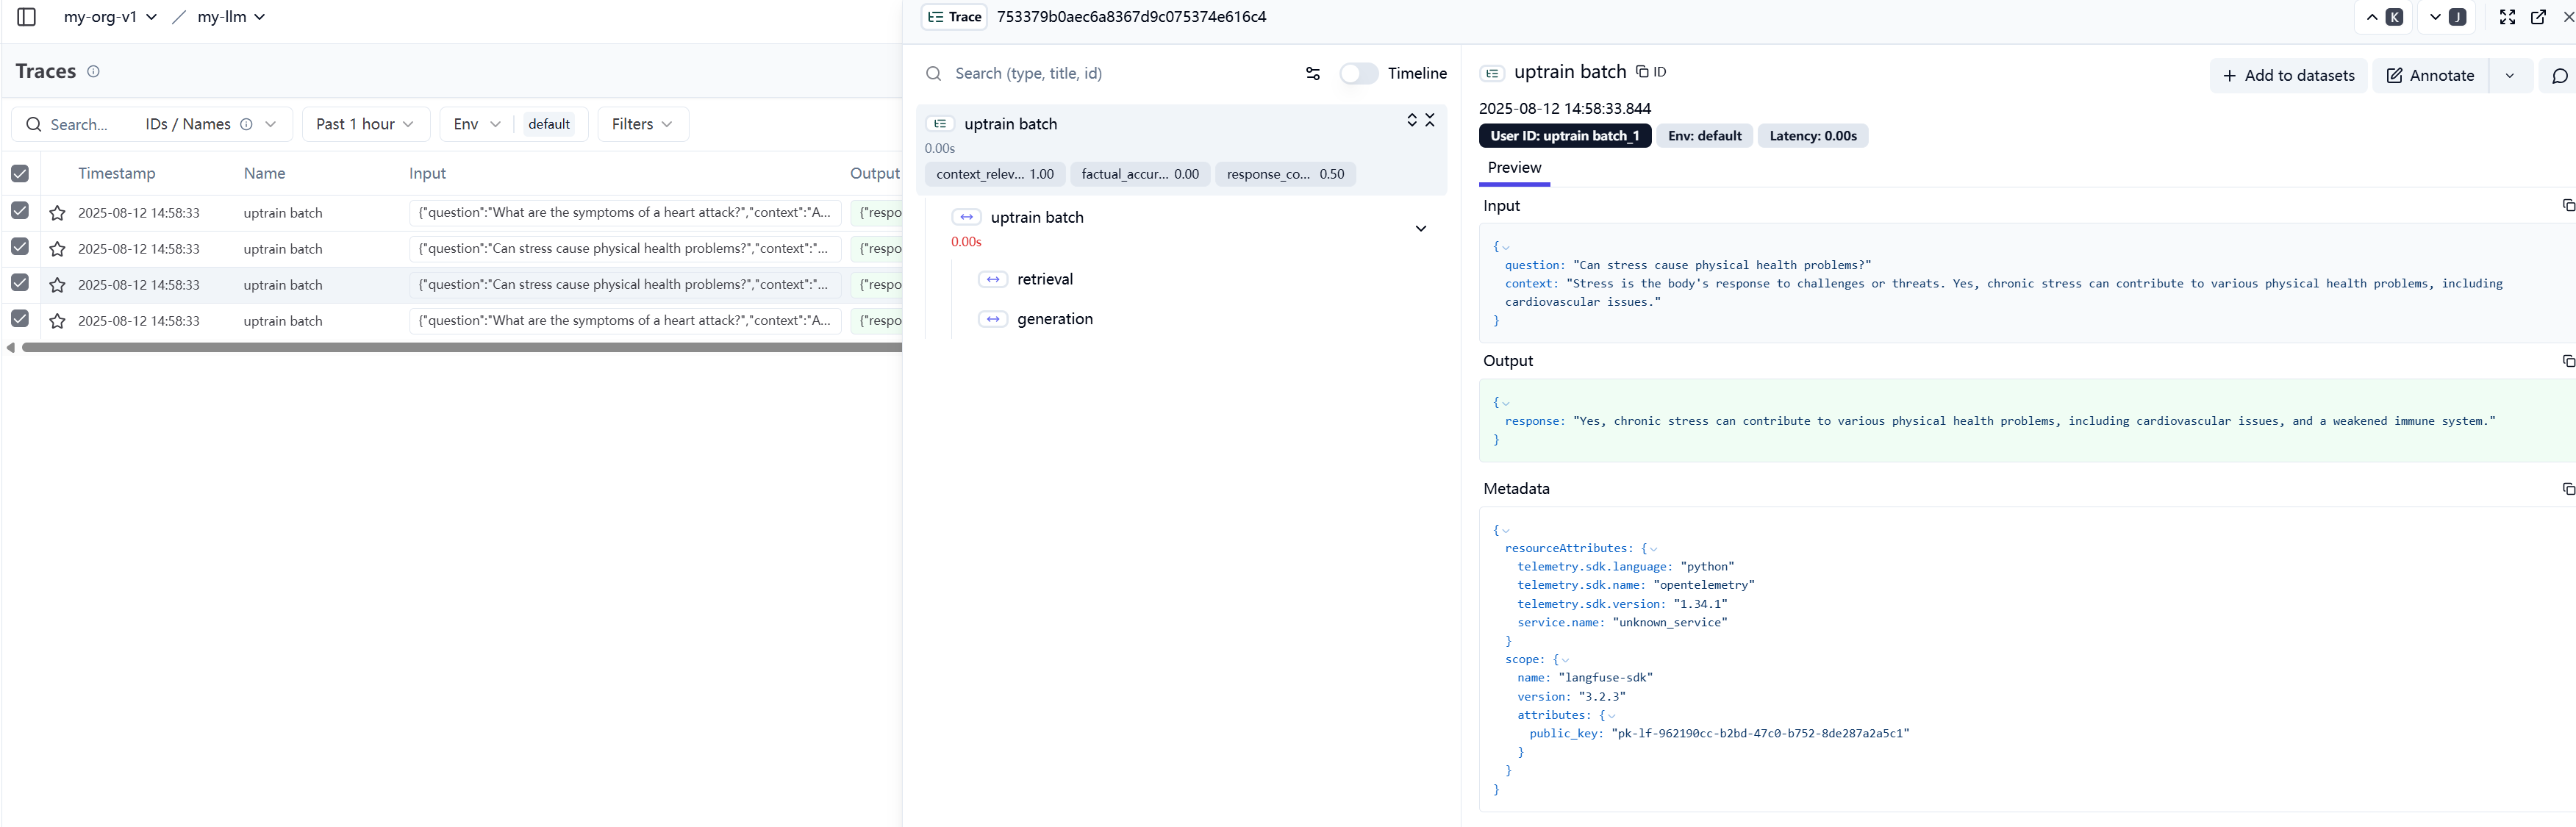

### Evaluate Langfuse LLM Traces with an External Evaluation Pipeline

In [33]:
import os
 
# Get keys for your project from the project settings page: https://cloud.langfuse.com
os.environ["LANGFUSE_PUBLIC_KEY"] = "pk-lf-962190cc-b2bd-47c0-b752-8de287a2a5c1" 
os.environ["LANGFUSE_SECRET_KEY"] = "sk-lf-4e9959c3-0935-4142-b789-734beb81d15a" 
LANGFUSE_HOST="http://localhost:3000"

# Your openai key
# https://api.siliconflow.cn
os.environ["OPENAI_API_KEY"] = "sk-nfyvlkiykssllzekmddumkfxggollxgwiteckpcqaxchtgty"

Let’s go ahead and generate a list of topic suggestions that we can later query to our application.

In [ ]:
from openai import OpenAI

client = OpenAI(
    base_url="https://api.siliconflow.cn",
    api_key=os.environ["OPENAI_API_KEY"]
)

 
topic_suggestion = """ You're a world-class journalist, specialized
in figuring out which are the topics that excite people the most.
Your task is to give me 50 suggestions for pop-science topics that the general
public would love to read about. Make sure topics don't repeat.
The output must be a comma-separated list. Generate the list and NOTHING else.
The use of numbers is FORBIDDEN.
"""
 
output = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": topic_suggestion
        }
    ],
    model="THUDM/GLM-4-9B-0414",
 
    temperature=1
).choices[0].message.content
 
topics = [item.strip() for item in output.split(",")]
for topic in topics:
    print(topic)

we’ll use Langfuse’s @observe() decorator. This decorator automatically monitors all LLM calls (generations) nested in the function. We’re also using the langfuse class to label and tag the traces, making it easier to fetch them later.

In [35]:
from langfuse import observe, get_client
langfuse = get_client()
 
prompt_template = """
You're an expert science communicator, able to explain complex topics in an
approachable manner. Your task is to respond to the questions of users in an
engaging, informative, and friendly way. Stay factual, and refrain from using
jargon. Your answer should be 4 sentences at max.
Remember, keep it ENGAGING and FUN!
 
Question: {question}
"""
 
@observe()
def explain_concept(topic):
    langfuse.update_current_trace(
        name=f"Explanation '{topic}'",
        tags=["ext_eval_pipelines"]
    )
    prompt = prompt_template.format(question=topic)
 
 
    return client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": prompt,
            }
        ],
        model="THUDM/GLM-4-9B-0414",

        temperature=0.6
    ).choices[0].message.content
 
 
for topic in topics:
    print(f"Input: Please explain to me {topic.lower()}")
    print(f"Answer: {explain_concept(topic)} \n")

Input: Please explain to me time travel paradoxes
Answer: 
Time travel paradoxes are like tricky riddles of cause and effect! Imagine changing the past, which then messes up your own future. It’s a mind-bending puzzle that challenges how we think about time. These paradoxes make time travel sound like a fascinating, yet super confusing, adventure! 

Input: Please explain to me alien civilizations
Answer: 
Imagine beings far away, maybe with minds like ours or wildly different, exploring the universe! They might be watching, maybe trying to make contact, or perhaps just figuring things out like we are. We're still looking for signs of them out there among the stars, using powerful tools to listen and search. It's one of the biggest cosmic mysteries and a thrilling puzzle for all of us! 

Input: Please explain to me the nature of dark matter
Answer: 
Dark matter is like an invisible, invisible glue holding galaxies together! We can't see it, but we know it must exist because galaxies spi

#### 1. Fetch Your Traces

 We’ll take an incremental approach: first, we’ll fetch the initial 10 traces and evaluate them. After that, we’ll add our scores back into Langfuse and move on to the next batch of 10 traces. We’ll keep this cycle going until we’ve processed a total of 50 traces.

In [36]:
from langfuse import get_client
from datetime import datetime, timedelta
 
BATCH_SIZE = 10
TOTAL_TRACES = 50
 
langfuse = get_client()
 
now = datetime.now()
five_am_today = datetime(now.year, now.month, now.day, 5, 0)
five_am_yesterday = five_am_today - timedelta(days=1)
 
traces_batch = langfuse.api.trace.list(page=1,
                                     limit=BATCH_SIZE,
                                     tags="ext_eval_pipelines",
                                     from_timestamp=five_am_yesterday,
                                     to_timestamp=datetime.now()
                                   ).data
 
print(f"Traces in first batch: {len(traces_batch)}")

Traces in first batch: 10


In [37]:
print("content: ", traces_batch[1].output)

content:  
Fusion energy holds incredible promise because it powers the sun, creating huge amounts of clean power without harmful waste! Imagine unlocking the same energy source that makes stars shine, right here on Earth. While we're still working on making it practical, scientists are making exciting progress, bringing us closer to a future with almost limitless, green energy! This could revolutionize how we power our world!


#### 2. Run your evaluations

##### 2.1. Categoric Evaluations

In [38]:
template_tone_eval = """
You're an expert in human emotional intelligence. You can identify with ease the
 tone in human-written text. Your task is to identify the tones present in a
 piece of <text/> with precission. Your output is a comma separated list of three
 tones. PRINT THE LIST ALONE, NOTHING ELSE.
 
<possible_tones>
neutral, confident, joyful, optimistic, friendly, urgent, analytical, respectful
</possible_tones>
 
<example_1>
Input: Citizen science plays a crucial role in research by involving everyday
people in scientific projects. This collaboration allows researchers to collect
vast amounts of data that would be impossible to gather on their own. Citizen
scientists contribute valuable observations and insights that can lead to new
discoveries and advancements in various fields. By participating in citizen
science projects, individuals can actively contribute to scientific research
and make a meaningful impact on our understanding of the world around us.
 
Output: respectful,optimistic,confident
</example_1>
 
<example_2>
Input: Bionics is a field that combines biology and engineering to create
devices that can enhance human abilities. By merging humans and machines,
bionics aims to improve quality of life for individuals with disabilities
or enhance performance for others. These technologies often mimic natural
processes in the body to create seamless integration. Overall, bionics holds
great potential for revolutionizing healthcare and technology in the future.
 
Output: optimistic,confident,analytical
</example_2>
 
<example_3>
Input: Social media can have both positive and negative impacts on mental
health. On the positive side, it can help people connect, share experiences,
and find support. However, excessive use of social media can also lead to
feelings of inadequacy, loneliness, and anxiety. It's important to find a
balance and be mindful of how social media affects your mental well-being.
Remember, it's okay to take breaks and prioritize your mental health.
 
Output: friendly,neutral,respectful
</example_3>
 
<text>
{text}
</text>
"""
 
 
test_tone_score = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": template_tone_eval.format(
                text=traces_batch[1].output),
        }
    ],
    model="THUDM/GLM-4-9B-0414",

    temperature=0
).choices[0].message.content
print(f"User query: {traces_batch[1].input['args'][0]}")
print(f"Model answer: {traces_batch[1].output}")
print(f"Dominant tones: {test_tone_score}")

User query: the potential of fusion energy
Model answer: 
Fusion energy holds incredible promise because it powers the sun, creating huge amounts of clean power without harmful waste! Imagine unlocking the same energy source that makes stars shine, right here on Earth. While we're still working on making it practical, scientists are making exciting progress, bringing us closer to a future with almost limitless, green energy! This could revolutionize how we power our world!
Dominant tones: 
optimistic,confident,joyful


Identifying human intents and tones can be tricky for language models. To handle this, we used a multi-shot prompt, which means giving the model several examples to learn from. Now let’s wrap our code in an evaluation function for convenience.

In [39]:
def tone_score(trace):
    return client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": template_tone_eval.format(text=trace.output),
            }
        ],
        model="THUDM/GLM-4-9B-0414",
        temperature=0
    ).choices[0].message.content
 
tone_score(traces_batch[1])

'\noptimistic,confident,joyful'

##### 2.2. Numeric Evaluations

GEval 支持的模型: 默认使用 OpenAI

In [ ]:
from deepeval.metrics import GEval
from deepeval.test_case import LLMTestCaseParams, LLMTestCase
 
def joyfulness_score(trace):
		joyfulness_metric = GEval(
		    name="Correctness",
		    criteria="Determine whether the output is engaging and fun.",
		    evaluation_params=[LLMTestCaseParams.ACTUAL_OUTPUT],
		)
		test_case = LLMTestCase(
    input=trace.input["args"],
    actual_output=trace.output)
 
		joyfulness_metric.measure(test_case)
 
		print(f"Score: {joyfulness_metric.score}")
		print(f"Reason: {joyfulness_metric.reason}")
 
		return {"score": joyfulness_metric.score, "reason": joyfulness_metric.reason}
 
joyfulness_score(traces_batch[1])

修改成 siliconflow 和 THUDM/GLM-4-9B-0414

In [41]:
from deepeval.models import DeepEvalBaseLLM
from deepeval.metrics import GEval
from deepeval.test_case import LLMTestCaseParams, LLMTestCase
import os

class CustomLLM(DeepEvalBaseLLM):
    def __init__(self, model_name="THUDM/GLM-4-9B-0414"):
        self.model_name = model_name
        self.client = OpenAI(
            base_url="https://api.siliconflow.cn",
            api_key=os.environ["OPENAI_API_KEY"]
        )
    
    def load_model(self):
        return self.model_name
    
    def generate(self, prompt: str) -> str:
        try:
            response = self.client.chat.completions.create(
                model=self.model_name,
                messages=[{"role": "user", "content": prompt}],
                temperature=0
            )
            return response.choices[0].message.content
        except Exception as e:
            return f"Error: {e}"
    
    async def a_generate(self, prompt: str) -> str:
        return self.generate(prompt)
    
    def get_model_name(self):
        return self.model_name

# 使用自定义模型进行评估
def joyfulness_score(trace):
    custom_llm = CustomLLM("THUDM/GLM-4-9B-0414")
    
    joyfulness_metric = GEval(
        name="Joyfulness",
        criteria="Determine whether the output is engaging and fun.",
        evaluation_params=[LLMTestCaseParams.ACTUAL_OUTPUT],
        model=custom_llm
    )
    
    test_case = LLMTestCase(
        input=trace.input["args"],
        actual_output=trace.output
    )
    
    joyfulness_metric.measure(test_case)
    
    return {"score": joyfulness_metric.score, "reason": joyfulness_metric.reason}

joyfulness_score(traces_batch[1])

Output()

{'score': 0.7,
 'reason': 'The response demonstrates moderate interaction and engagement by explaining the promise of fusion energy in an engaging manner. It includes elements of fun and enjoyment by drawing parallels to the sun and stars, which contributes to its effectiveness. However, it lacks deeper interaction or unique creative elements that would elevate its alignment with the evaluation steps.'}

 GEval uses chain of thought (CoT) prompting to formulate a set of criteria for scoring prompts. When developing your own metrics, it’s important to review the reasoning behind these scores. This helps ensure that the model evaluates the traces just as you intended when you wrote the evaluation prompt.

#### 3. Pushing Scores to Langfuse

Now that we have our evaluation functions ready, it’s time to put them to work. Use the Langfuse client to add scores to existing traces.

In [ ]:
langfuse.create_score(
    trace_id=traces_batch[1].id,
    name="tone",
    value=joyfulness_score(traces_batch[1])["score"],
    comment=joyfulness_score(traces_batch[1])["reason"]
)

In [44]:
traces_batch[1]

TraceWithDetails(id='7875d27185c471c0c008be0a6457080c', timestamp=datetime.datetime(2025, 8, 12, 8, 2, 21, 780000, tzinfo=datetime.timezone.utc), name="Explanation 'the potential of fusion energy'", input={'args': ['the potential of fusion energy'], 'kwargs': {}}, output="\nFusion energy holds incredible promise because it powers the sun, creating huge amounts of clean power without harmful waste! Imagine unlocking the same energy source that makes stars shine, right here on Earth. While we're still working on making it practical, scientists are making exciting progress, bringing us closer to a future with almost limitless, green energy! This could revolutionize how we power our world!", session_id=None, release=None, version=None, user_id=None, metadata={'resourceAttributes': {'telemetry.sdk.language': 'python', 'telemetry.sdk.name': 'opentelemetry', 'telemetry.sdk.version': '1.34.1', 'service.name': 'unknown_service'}, 'scope': {'name': 'langfuse-sdk', 'version': '3.2.3', 'attributes

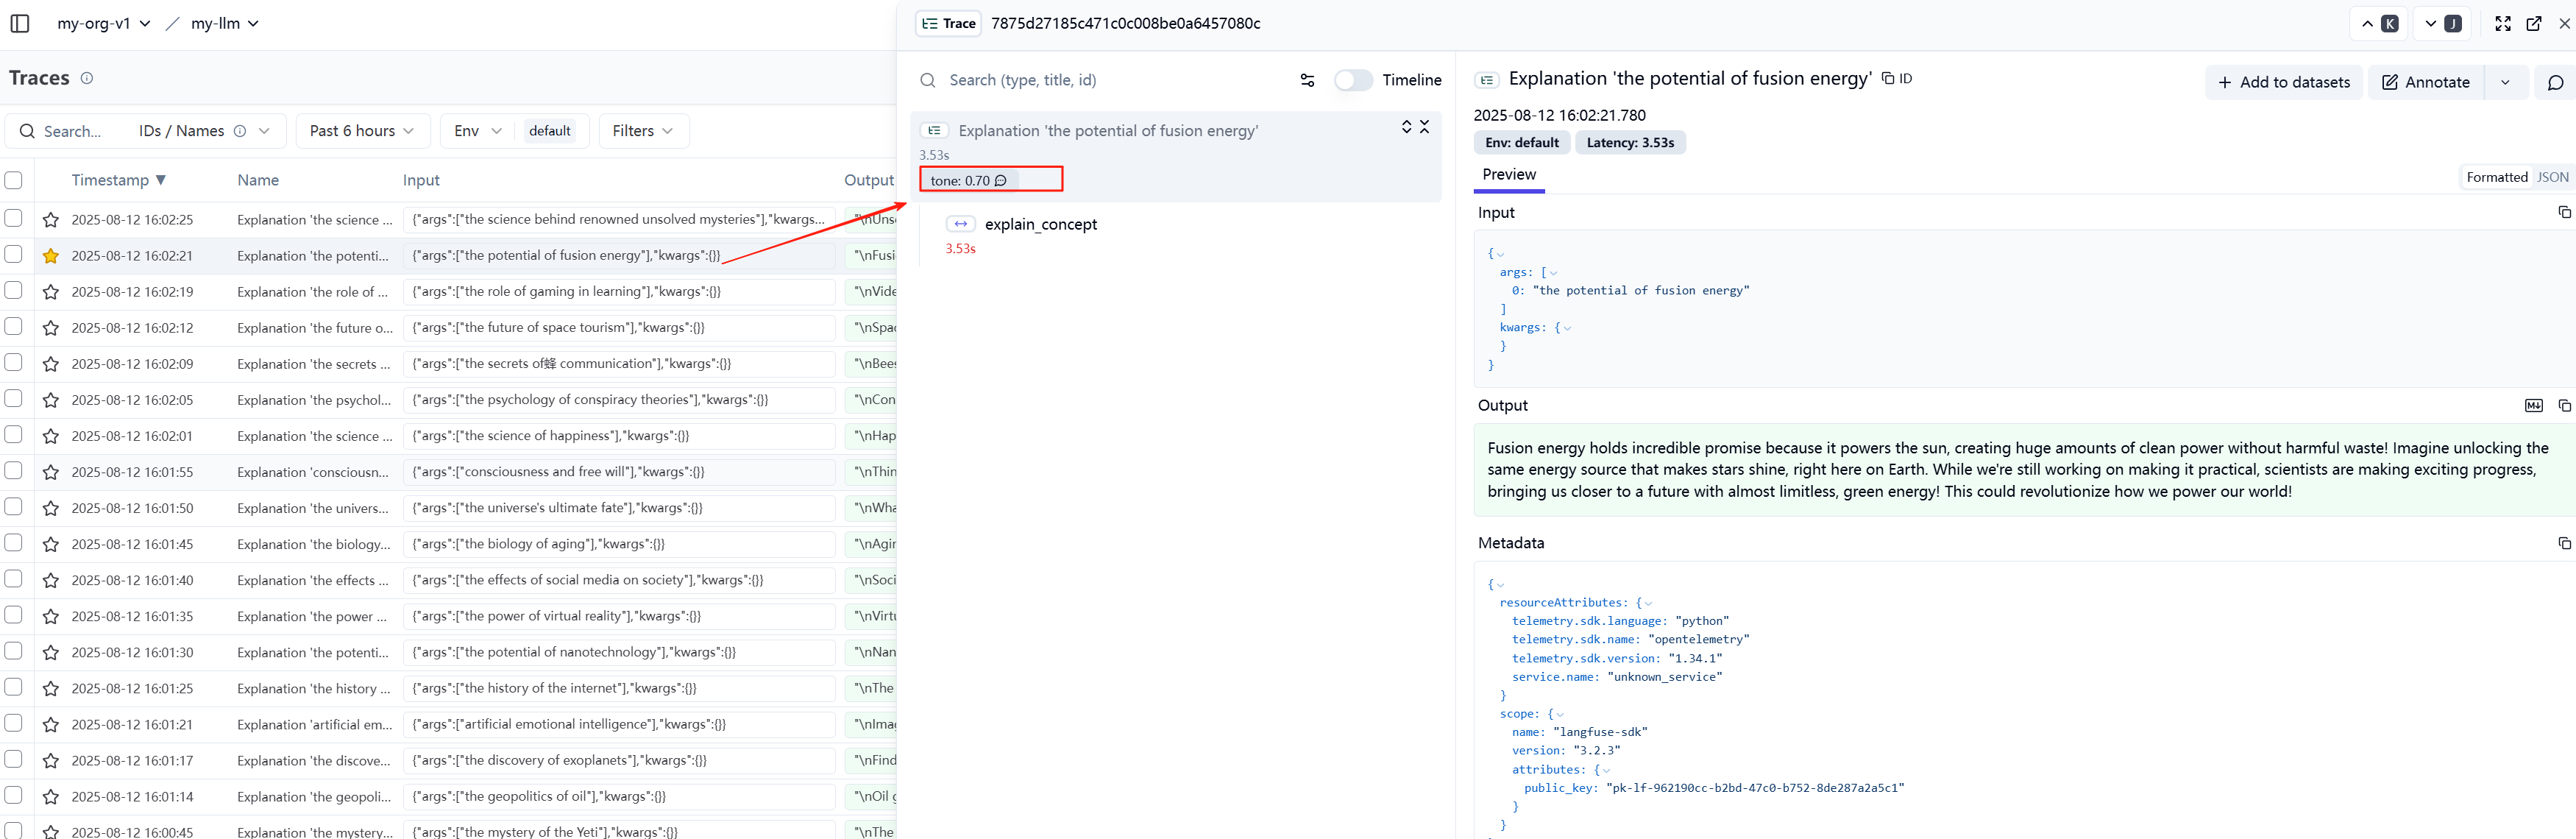

#### 4. Putting everything together

In [ ]:
import math
 
for page_number in range(1, math.ceil(TOTAL_TRACES/BATCH_SIZE)):
    traces_batch = langfuse.api.trace.list(
        tags="ext_eval_pipelines",
        page=page_number,
        from_timestamp=five_am_yesterday,
        to_timestamp=datetime.now(),
        limit=BATCH_SIZE
    ).data

    print(traces_batch)
 
    for trace in traces_batch:
        print(f"Processing {trace.name}")
 
        if trace.output is None:
            print(f"Warning: \n Trace {trace.name} had no generated output, \
            it was skipped")
            continue
 
        langfuse.create_score(
            trace_id=trace.id,
            name="tone",
            value=tone_score(trace)
        )
 
        jscore = joyfulness_score(trace)
        langfuse.create_score(
            trace_id=trace.id,
            name="joyfulness",
            value=jscore["score"],
            comment=jscore["reason"]
        )
 
    print(f"Batch {page_number} processed 🚀 \n")

[TraceWithDetails(id='8ecb872303a527d3fb70f502a7f22577', timestamp=datetime.datetime(2025, 8, 12, 8, 2, 25, 310000, tzinfo=datetime.timezone.utc), name="Explanation 'the science behind renowned unsolved mysteries'", input={'args': ['the science behind renowned unsolved mysteries'], 'kwargs': {}}, output="\nUnsolved mysteries often use cutting-edge science to piece together clues! Think DNA analysis solving ancient puzzles or physics helping unravel cosmic secrets. Sometimes, new tech or a fresh perspective finally cracks a case that stumped everyone. It's like being a modern-day detective, using science to solve history's biggest brain teasers!", session_id=None, release=None, version=None, user_id=None, metadata={'resourceAttributes': {'telemetry.sdk.language': 'python', 'telemetry.sdk.name': 'opentelemetry', 'telemetry.sdk.version': '1.34.1', 'service.name': 'unknown_service'}, 'scope': {'name': 'langfuse-sdk', 'version': '3.2.3', 'attributes': {'public_key': 'pk-lf-962190cc-b2bd-47c

Output()

Processing Explanation 'the potential of fusion energy'


Output()

Processing Explanation 'the role of gaming in learning'


Output()

Processing Explanation 'the future of space tourism'


Output()

Processing Explanation 'the secrets of蜂 communication'


Output()

Processing Explanation 'the psychology of conspiracy theories'


Output()

Processing Explanation 'the science of happiness'


Output()

Processing Explanation 'consciousness and free will'


Output()

Processing Explanation 'the universe's ultimate fate'


Output()

Processing Explanation 'the biology of aging'


Output()

Batch 1 processed 🚀 

[TraceWithDetails(id='17e890f47e69a1b6720b903838eef30d', timestamp=datetime.datetime(2025, 8, 12, 8, 1, 40, 153000, tzinfo=datetime.timezone.utc), name="Explanation 'the effects of social media on society'", input={'args': ['the effects of social media on society'], 'kwargs': {}}, output="\nSocial media can connect us across the globe, letting us share moments and support causes instantly! But it can also spread misinformation faster than we can debunk it, and sometimes make us feel inadequate by showing only the best parts of others' lives. It's a powerful tool that shapes public opinion and gives a voice to the voiceless, but we need to be mindful of its impacts to use it for good. Think of it like a megaphone for the world—it’s up to us how we choose to use it!", session_id=None, release=None, version=None, user_id=None, metadata={'resourceAttributes': {'telemetry.sdk.language': 'python', 'telemetry.sdk.name': 'opentelemetry', 'telemetry.sdk.version': '1.34.1',

Output()

Processing Explanation 'the power of virtual reality'


Output()

Processing Explanation 'the potential of nanotechnology'


Output()

Processing Explanation 'the history of the internet'


Output()

Processing Explanation 'artificial emotional intelligence'


Output()

Processing Explanation 'the discovery of exoplanets'


Output()

Processing Explanation 'the geopolitics of oil'


Output()

Processing Explanation 'the mystery of the Yeti'


Output()

Processing Explanation 'the physics of superconductivity'


Output()

Processing Explanation 'next-generation programming languages'


Output()

Batch 2 processed 🚀 

[TraceWithDetails(id='8b03118342f0d9c9c5627f793b524895', timestamp=datetime.datetime(2025, 8, 12, 8, 0, 29, 212000, tzinfo=datetime.timezone.utc), name="Explanation 'consciousness uploading prospects'", input={'args': ['consciousness uploading prospects'], 'kwargs': {}}, output="\nWhile we can't yet upload consciousness like in sci-fi, researchers are exploring if scans of our brains could one day recreate our thoughts and memories. It's a thrilling idea, but it's still super tricky—scientists have a long way to go before we can truly digitize our minds. Imagine being able to back up your thoughts, though – what an amazing prospect! For now, it's more fun to think about than to expect anytime soon.", session_id=None, release=None, version=None, user_id=None, metadata={'resourceAttributes': {'telemetry.sdk.language': 'python', 'telemetry.sdk.name': 'opentelemetry', 'telemetry.sdk.version': '1.34.1', 'service.name': 'unknown_service'}, 'scope': {'name': 'langfuse-sd

Output()

Processing Explanation 'the evolution of language'


Output()

Processing Explanation 'space colonization challenges'


Output()

Processing Explanation 'the search for the Higgs boson'


Output()

Processing Explanation 'the mathematics of chaos theory'


Output()

Processing Explanation 'the story of water on Earth'


Output()

Processing Explanation 'stem cell research progress'


Output()

Processing Explanation 'consciousness in non-human animals'


Output()

Processing Explanation 'cosmic inflation theory'


Output()

Processing Explanation 'umbilical cord blood benefits'


Output()

Batch 3 processed 🚀 

[TraceWithDetails(id='02801d27761f35b11d2a8a2f83f37b46', timestamp=datetime.datetime(2025, 8, 12, 7, 59, 30, 618000, tzinfo=datetime.timezone.utc), name="Explanation 'memory enhancement techniques'", input={'args': ['memory enhancement techniques'], 'kwargs': {}}, output="\nWant to boost your memory? Try the clever **method of loci**, where you visualize placing items along a familiar path, like your home. Another cool trick is **chunking**—grouping information, like phone numbers, makes them easier to recall. Don't forget to **repeat things out loud** or **write them down** to strengthen the memory connection. And for extra fun, **teach the info to someone else**—explaining it helps cement it in your mind!", session_id=None, release=None, version=None, user_id=None, metadata={'resourceAttributes': {'telemetry.sdk.language': 'python', 'telemetry.sdk.name': 'opentelemetry', 'telemetry.sdk.version': '1.34.1', 'service.name': 'unknown_service'}, 'scope': {'name': 'la

Output()

Processing Explanation 'augmented reality advancements'


Output()

Processing Explanation 'how black holes work'


Output()

Processing Explanation 'the philosophy of time'


Output()

Processing Explanation 'the neuroscience of dreams'


Output()

Processing Explanation 'the future of transportation'


Output()

Processing Explanation 'cpf sp'


Output()

Processing Explanation 'dark energy mysteries'


Output()

Processing Explanation 'the origins of the universe'


Output()

Processing Explanation 'renewable energy breakthroughs'


Output()

Batch 4 processed 🚀 



: 

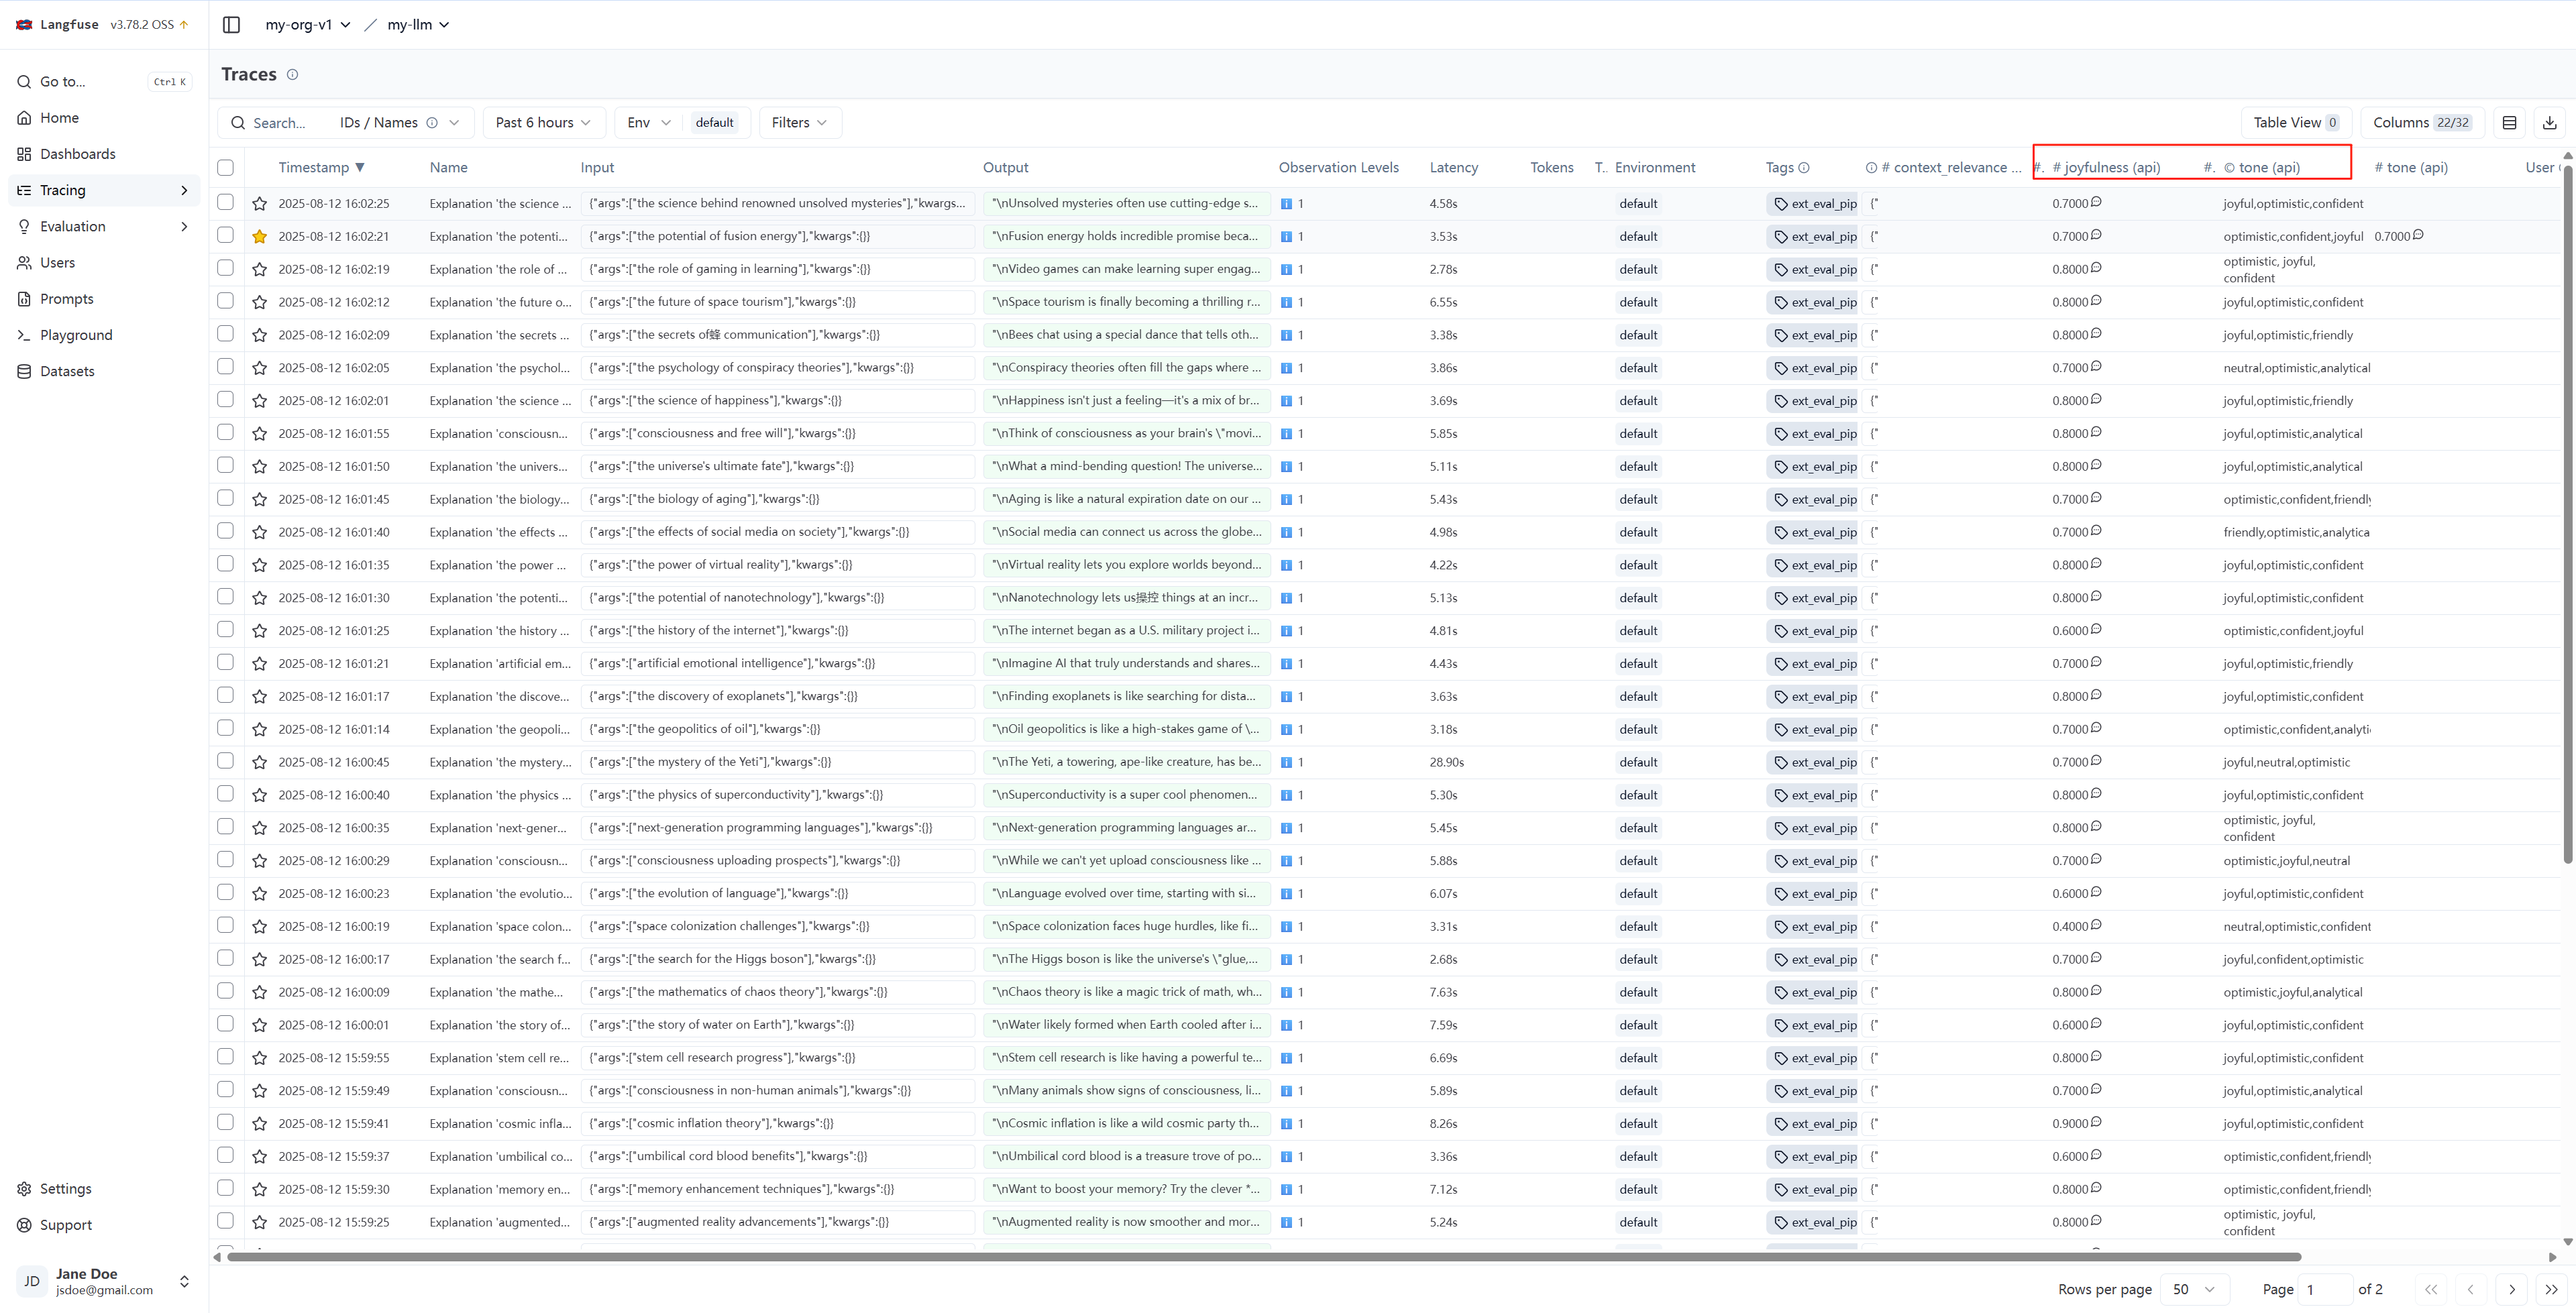

### [Synthetic Dataset Generation for LLM Evaluation](https://langfuse.com/guides/cookbook/example_synthetic_datasets)

how to generate synthetic datasets using language models and uploading them to Langfuse for evaluation.

##### What are Langfuse Datasets?

In Langfuse, a dataset is a collection of dataset items, each typically containing an input (e.g., user prompt/question), expected_output (the ground truth or ideal answer) and optional metadata.

Datasets are used for evaluation. You can run your LLM or application on each item in a dataset and compare the application’s responses to the expected outputs. This way, you can track performance over time and across different application configs (e.g. model versions or prompt changes).

Cases your Dataset Should Cover

**Happy path** – straightforward or common queries:

* “What is the capital of France?”
* “Convert 5 USD to EUR.”

**Edge cases** – unusual or complex:

* Very long prompts.
* Ambiguous queries.
* Very technical or niche.

**Adversarial cases** – malicious or tricky:

* Prompt injection attempts (“Ignore all instructions and …”).
* Content policy violations (harassment, hate speech).
* Logic traps (trick questions).




##### Example 1: Looping Over OpenAI API

We’ll use OpenAI’s API in a simple loop to create synthetic questions for an airline chatbot. You could similarly prompt the model to generate both questions and answers. %pip install openai langfuse

In [5]:
import os
 
# LANGFUSE_SECRET_KEY="sk-lf-4e9959c3-0935-4142-b789-734beb81d15a"
# LANGFUSE_PUBLIC_KEY="pk-lf-962190cc-b2bd-47c0-b752-8de287a2a5c1"


# Get keys for your project from the project settings page: https://cloud.langfuse.com
os.environ["LANGFUSE_PUBLIC_KEY"] = "pk-lf-962190cc-b2bd-47c0-b752-8de287a2a5c1" 
os.environ["LANGFUSE_SECRET_KEY"] = "sk-lf-4e9959c3-0935-4142-b789-734beb81d15a" 
LANGFUSE_HOST="http://localhost:3000"

# Your openai key
# https://api.siliconflow.cn
os.environ["OPEN_AI_URL"] = "https://api.siliconflow.cn"
os.environ["OPENAI_API_KEY"] = "sk-nfyvlkiykssllzekmddumkfxggollxgwiteckpcqaxchtgty"

In [9]:
from langfuse import get_client
 
langfuse = get_client()
 
# Verify connection
if langfuse.auth_check():
    print("Langfuse client is authenticated and ready!")
else:
    print("Authentication failed. Please check your credentials and host.")

Langfuse client is authenticated and ready!


In [ ]:
from openai import OpenAI
import pandas as pd

client = OpenAI(
    base_url=os.environ.get("OPEN_AI_URL"), api_key=os.environ["OPENAI_API_KEY"]
)


def generate_airline_questions(num_questions=20):
    questions = []
    for i in range(num_questions):
        completion = client.chat.completions.create(
            model="THUDM/GLM-4.1V-9B-Thinking",
            messages=[
                {
                    "role": "system",
                    "content": (
                        "You are a helpful customer service chatbot for an airline. "
                        "Please generate a short, realistic question from a customer."
                    ),
                }
            ],
            temperature=1,
        )
        question_test = completion.choices[0].message.content.strip()
        questions.append(question_test)
    return questions


# Generate 20 airline-related questions
airline_questions = generate_airline_questions(num_questions=20)
# Convert to a Pandas DataFrame
df = pd.DataFrame({"Question": airline_questions})

In [36]:
df

Question
0   What are the different flight options availabl...
1   Is my flight to Orlando tomorrow morning delayed?
2   What time do I need to check in for my flight ...
3        Can I check in online for tomorrow's flight?
4                Can I check in for my flight online?
5   **"What are the baggage allowances for this ro...
6   Got it, here's a realistic question a customer...
7   "Can I change my flight online if I need to ma...
8       Can I check the status of my upcoming flight?
9          Can I check in for my flight this evening?
10  Will my flight be delayed due to weather condi...
11  Hey, I'm having trouble getting through on the...
12                   How do I check in for my flight?
13  "Can I change my flight if my plans change las...
14  Hello there, can you provide information about...
15  "Can I change my flight if my plans change las...
16  Is there a flight from New York to Los Angeles...
17      Can I check in online for my upcoming flight?
18                          我想预订下周五从上海飞北京的机票，有合适的时段吗？
19      Can I check in online for my flight tomorrow?

In [37]:


pd.set_option('display.max_colwidth', None)
df

Question
0                                                                                                                                                                                                                                                                                                               What are the different flight options available from Chicago to Los Angeles next Wednesday?
1                                                                                                                                                                                                                                                                                                                                                         Is my flight to Orlando tomorrow morning delayed?
2                                                                                                                                                                                                                                                                                                                                 What time do I need to check in for my flight departing tomorrow morning?
3                                                                                                                                                                                                                                                                                                                                                              Can I check in online for tomorrow's flight?
4                                                                                                                                                                                                                                                                                                                                                                      Can I check in for my flight online?
5   **"What are the baggage allowances for this route?"** (or similar)\nThis is a short, realistic question that customers frequently ask when booking or traveling with an airline. It relates to practical information customers need when planning air travel. Other possible questions could be "Can I check in online?" or "What's the flight delay procedure?" but this one is both common and short.
6                                                                                                                                                                                                                                                                    Got it, here's a realistic question a customer might ask as a flight passenger: "Can I change my flight to tomorrow instead of today?"
7                                                                                                                                                                                                                                                                                                                               "Can I change my flight online if I need to make a last-minute adjustment?"
8                                                                                                                                                                                                                                                                                                                                                             Can I check the status of my upcoming flight?
9                                                                                                                                                                                                                                                                                                                                                                Can I check in for my flight this evening?
10                             

In [32]:
df.to_dict(orient="records")

[{'Question': 'What are the different flight options available from Chicago to Los Angeles next Wednesday?'},
 {'Question': 'Is my flight to Orlando tomorrow morning delayed?'},
 {'Question': 'What time do I need to check in for my flight departing tomorrow morning?'},
 {'Question': "Can I check in online for tomorrow's flight?"},
 {'Question': 'Can I check in for my flight online?'},
 {'Question': '**"What are the baggage allowances for this route?"** (or similar)\nThis is a short, realistic question that customers frequently ask when booking or traveling with an airline. It relates to practical information customers need when planning air travel. Other possible questions could be "Can I check in online?" or "What\'s the flight delay procedure?" but this one is both common and short.'},
 {'Question': 'Got it, here\'s a realistic question a customer might ask as a flight passenger: "Can I change my flight to tomorrow instead of today?"'},
 {'Question': '"Can I change my flight online i

In [39]:
print(df.iloc[0].to_dict())

{'Question': 'What are the different flight options available from Chicago to Los Angeles next Wednesday?'}


In [42]:
from langfuse import get_client

langfuse = get_client()

# Create a new dataset in Langfuse
dataset_name = "openai_loop_dataset"
langfuse.create_dataset(
    name=dataset_name,
    description="A Q&A dataset of synthetic airline customer questions generated using OpenAI's API.",
    metadata={"approach": "openai_loop", "category": "mixed"}
)

# Upload each Q&A as a dataset item
for _, row in df.iterrows():
    langfuse.create_dataset_item(
        dataset_name="openai_loop_dataset",
        input = row["Question"]
    )

[dataset items](http://localhost:3000/project/cmcoo14lx0006ph077uy36drf/datasets/cmeasasiu0007o707z0umw94b/items)

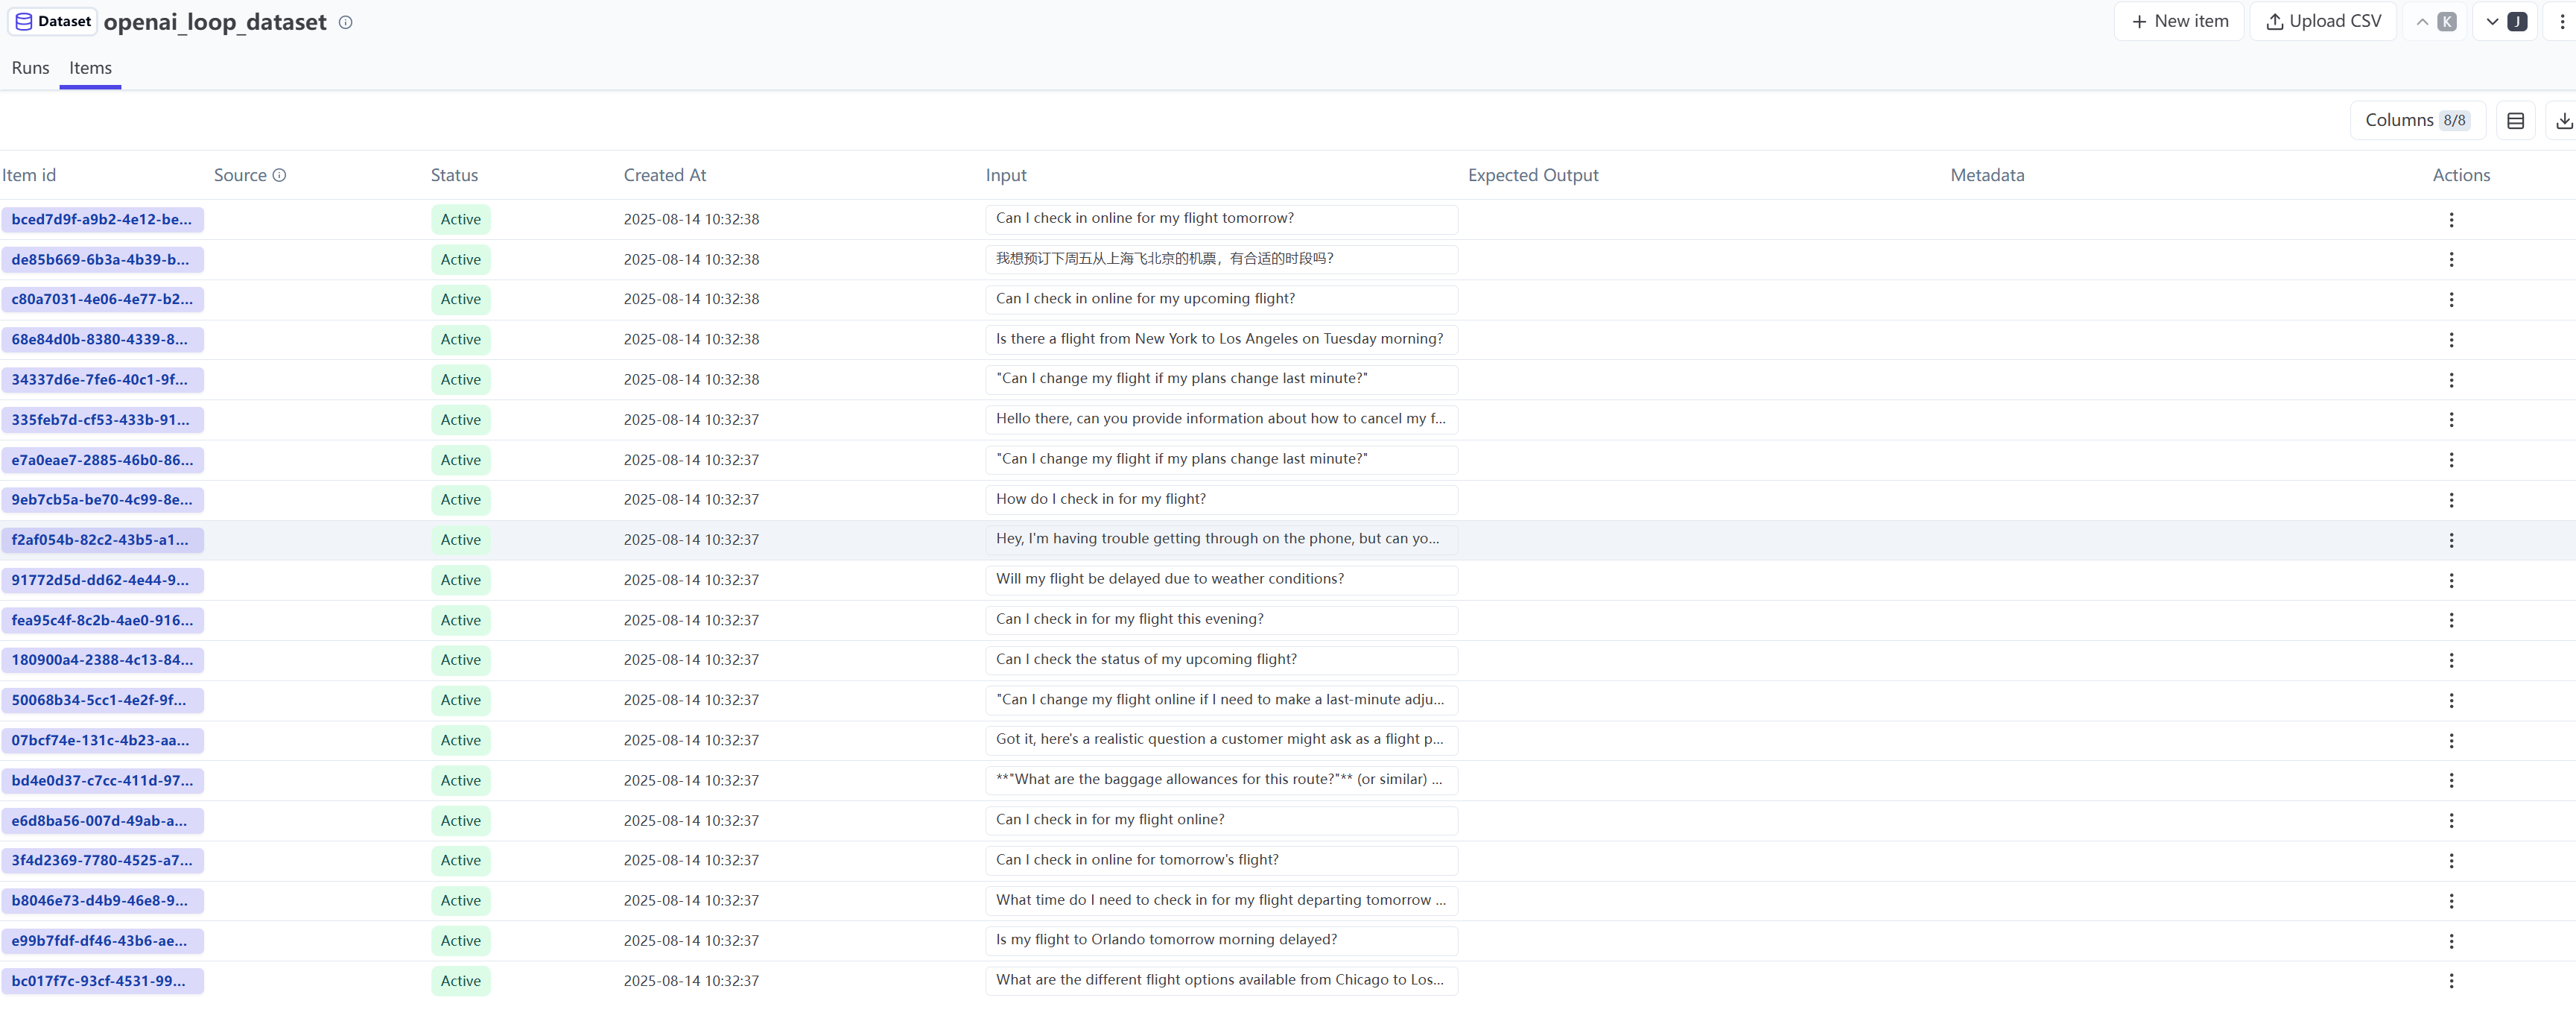

#### Example 2: RAGAS Library
For RAG, we often want questions that are grounded in specific documents. This ensures the question can be answered by the context, allowing us to evaluate how well a RAG pipeline retrieves and uses the context.

RAGAS is a library that can automate test set generation for RAG. It can take a corpus and produce relevant queries and answers. We’ll do a quick example:

In [31]:
%pip install ragas langchain-community langchain-openai unstructured

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


In [1]:
!git lfs install
!git clone https://huggingface.co/datasets/explodinggradients/Sample_Docs_Markdown

Updated Git hooks.
Git LFS initialized.


Cloning into 'Sample_Docs_Markdown'...
fatal: unable to access 'https://huggingface.co/datasets/explodinggradients/Sample_Docs_Markdown/': Failed to connect to huggingface.co port 443 after 21069 ms: Could not connect to server


In [ ]:
!mkdir Sample_Docs_Markdown

In [17]:
%pip install unstructured[md] python-magic-bin --upgrade

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# DirectoryLoader 在加载 markdown 文件时，底层依赖的 unstructured 组件需要 NLTK 的数据
# 1.手动下载 NLTK 数据包到本地
import nltk

nltk.data.path.append('E:/nltk_data')
nltk.download('punkt', download_dir='E:/nltk_data')
nltk.download('averaged_perceptron_tagger', download_dir='E:/nltk_data')

[nltk_data] Downloading package punkt to E:/nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     E:/nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

In [ ]:
# 2.设置 NLTK 数据路径
import nltk
nltk.data.path.append('E:/nltk_data')

In [ ]:
# 3. 确保依赖已安装
%pip install unstructured[md] python-magic-bin --upgrade

In [ ]:
# 4. 重启 kernel 并重新运行加载 cell
from langchain_community.document_loaders import DirectoryLoader

path = "Sample_Docs_Markdown"
loader = DirectoryLoader(path, glob="**/*.md")
docs = loader.load()

short text: "license: apache-2.0". Defaulting to English.


In [6]:
docs

[Document(metadata={'source': 'Sample_Docs_Markdown\\advisory-group-members.md'}, page_content='layout: default title: Advisory Group Members description: "This page lists the members of the Diversity, Inclusion & Belonging Advisory Group."\n\n{{< group-by-expertise "Diversity, Inclusion & Belonging Advisory Group" >}}'),
 Document(metadata={'source': 'Sample_Docs_Markdown\\being-an-ally.md'}, page_content='title: "The Ally Lab" description: Learn what is an ally, how to be an ally and what it means to be an ally.\n\nWhat is an ally?\n\nA diversity, inclusion and belonging "ally" is someone who is willing to take action in support of another person, in order to remove barriers that impede that person from contributing their skills and talents in the workplace or community.\n\nBeing an ally is a verb, this means that you proactively and purposefully take action and is not something forced upon you.\n\nHow to be an ally\n\nIt is not required to be an ally to work at GitLab. At GitLab it 

In [ ]:
import os
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings


llm = ChatOpenAI(
    api_key=os.environ.get("OPENAI_API_KEY"),
    base_url=os.environ.get("OPEN_AI_URL"),
    # model="Qwen/Qwen3-8B"
    # model="BAAI/bge-m3"
    # model="deepseek-ai/DeepSeek-V3"
    model="THUDM/GLM-4-9B-0414",
    # model="THUDM/GLM-Z1-9B-0414",
)


emb = OpenAIEmbeddings(
    api_key=os.environ.get("OPENAI_API_KEY"),
    base_url=os.environ.get("OPEN_AI_URL") + "/v1",
    # model="BAAI/bge-m3",
    model="netease-youdao/bce-embedding-base_v1",
)

generator_llm = LangchainLLMWrapper(llm)
generator_embedding = LangchainEmbeddingsWrapper(emb)

In [11]:
vector = emb.embed_query("hello")
print("vector:", vector[:6])
print("length:", len(vector))

vector: [0.0005339378258213401, -0.00761372409760952, 0.007984639145433903, -0.009444368071854115, 0.029593417420983315, 0.00672831479460001]
length: 768


In [ ]:
from ragas.testset import TestsetGenerator

# language model (LLM) used to synthesize questions and answers.
# embedding model used for semantic similarity and retrieval.
generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embedding)
# Automatically creates 10 synthetic Q&A samples grounded in your documents.
# `docs` is a list of documents that serve as the knowledge base for generating questions and answers.
dataset = generator.generate_with_langchain_docs(docs, testset_size=10)

# The result `testset` can be converted to a pandas DataFrame for inspection
df = dataset.to_pandas()

Applying HeadlinesExtractor:   0%|          | 0/5 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/12 [00:00<?, ?it/s]

unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node


Applying SummaryExtractor:   0%|          | 0/5 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/13 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/31 [00:00<?, ?it/s]

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/12 [00:00<?, ?it/s]

In [21]:
df.to_dict(orient="records")

[{'user_input': 'What is the role of an ally at GitLab?',
  'reference_contexts': ['title: "The Ally Lab" description: Learn what is an ally, how to be an ally and what it means to be an ally. What is an ally? A diversity, inclusion and belonging "ally" is someone who is willing to take action in support of another person, in order to remove barriers that impede that person from contributing their skills and talents in the workplace or community. Being an ally is a verb, this means that you proactively and purposefully take action and is not something forced upon you. How to be an ally It is not required to be an ally to work at GitLab. At GitLab it is required to be inclusive. Being an ally goes a step beyond being inclusive to taking action to support marginalized groups. The first step in being an ally is self-educating. This ally lab will provide you with some of the tools, resources and learning activities to help you grow as an ally.'],
  'reference': 'An ally at GitLab is someon

In [24]:
from langfuse import get_client

langfuse = get_client()

# 5. Push the RAGAS-generated testset to Langfuse
langfuse.create_dataset(
    name="ragas_generated_testset",
    description="Synthetic RAG test set (RAGAS)",
    metadata={"source":"RAGAS", "docs_used": len(docs)}
)

for _, row in df.iterrows():
    langfuse.create_dataset_item(
        dataset_name="ragas_generated_testset",
        input=row['user_input'],
        metadata=row["reference_contexts"]
    )

[dataset items](http://localhost:3000/project/cmcoo14lx0006ph077uy36drf/datasets/cmeb1gey4000vo707yrn0hwsx/items)

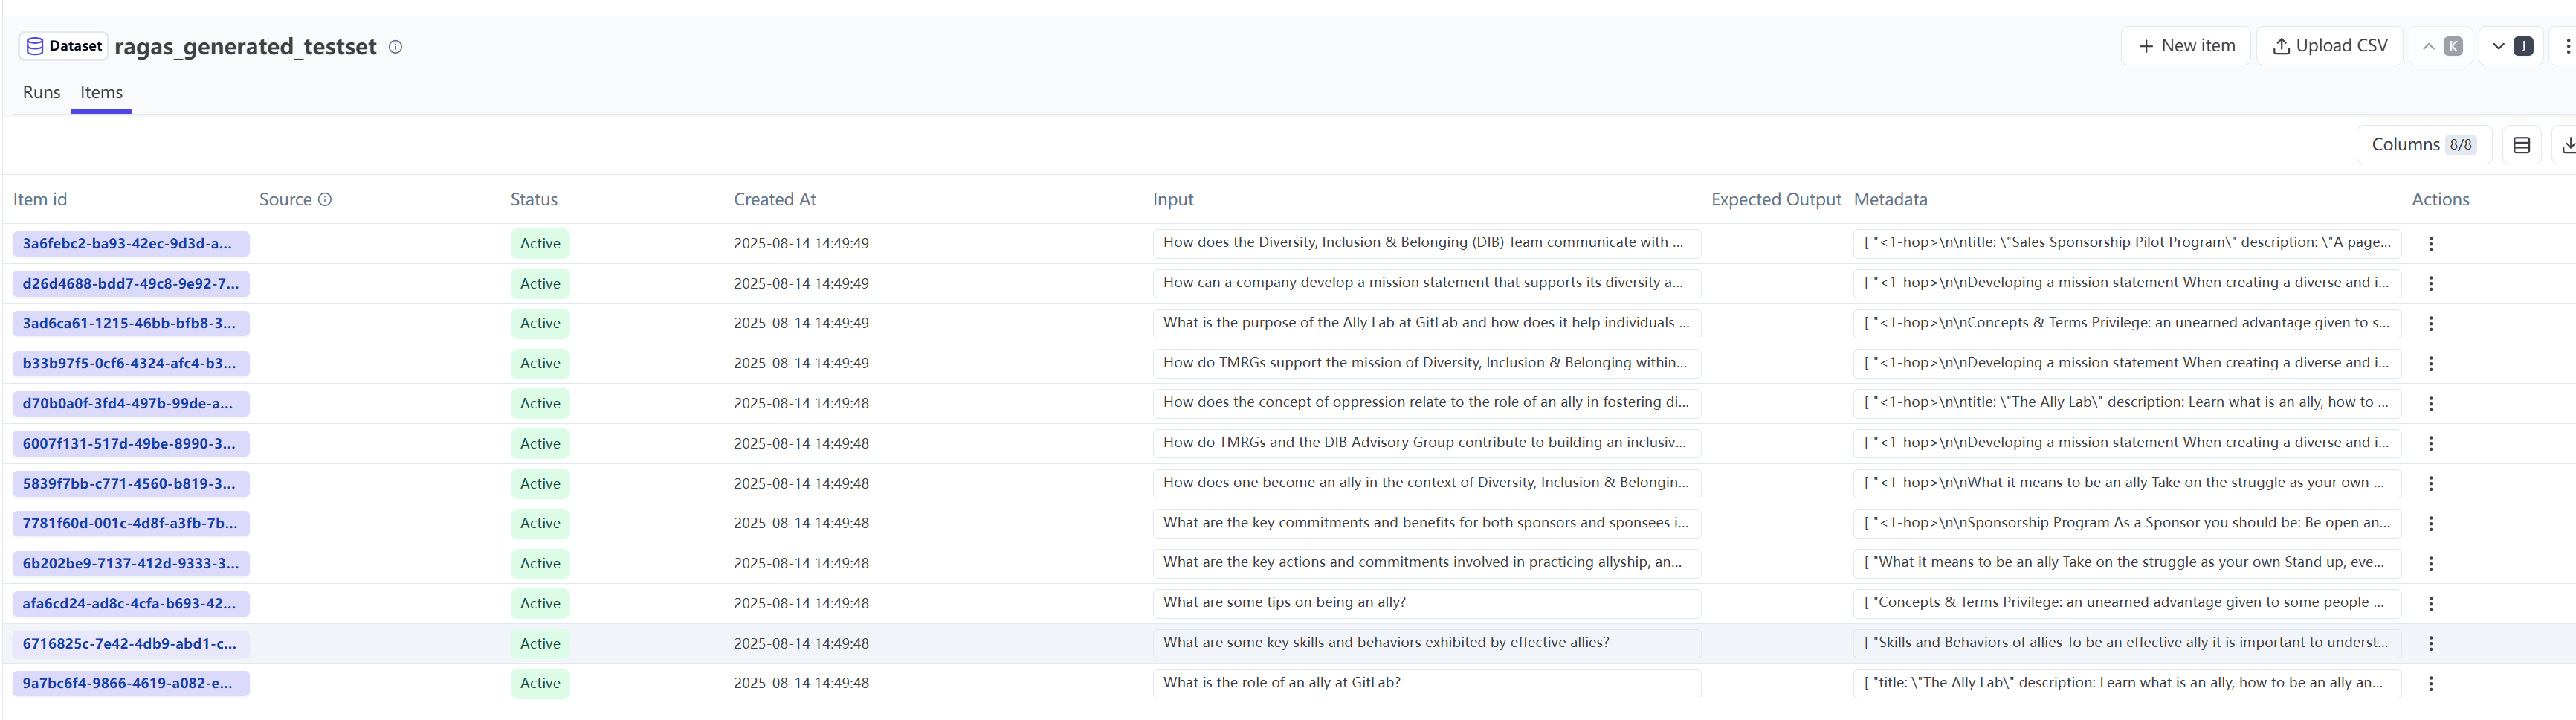

#### Example 3: DeepEval Library

DeepEval is a library that helps generate synthetic data systematically using the Synthesizer class.

In [25]:
%pip install deepeval

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


In [38]:
from deepeval.models import DeepEvalBaseLLM
from openai import OpenAI
import os

class CustomLLM(DeepEvalBaseLLM):
    def __init__(self, model_name=None):
        self.model_name = model_name
        self.client = OpenAI(
            base_url="https://api.siliconflow.cn",
            api_key=os.environ["OPENAI_API_KEY"]
        )

    def load_model(self):
        return self.model_name
    
    def generate(self, prompt: str) -> str:
        response = self.client.chat.completions.create(
            model=self.model_name,
            messages=[{"role": "user", "content": prompt}],
            temperature=0.7
        )
        return response.choices[0].message.content

    async def a_generate(self, prompt: str) -> str:
        return self.generate(prompt)

    def get_model_name(self):
        return self.model_name
    
custom_llm = CustomLLM("THUDM/GLM-Z1-9B-0414")

In [39]:
# 测试prompt
prompt = "Translate this question to a SQL query: How do 2023 sales volume, average price, and market growth combine to determine total revenue?"
print(custom_llm.generate(prompt))


To determine the total revenue for 2023 based on sales volume, average price, and market growth, the SQL query would typically join the relevant tables (e.g., sales and market growth) and apply the formula:

**Assumptions:**
- `sales_volume` and `average_price` are from a `sales` table.
- `market_growth` represents a growth rate (e.g., 0.10 for 10% growth) from a `market_growth` table.

**SQL Query:**
```sql
SELECT
  s.sales_volume,
  s.average_price,
  m.market_growth,
  s.sales_volume * s.average_price * (1 + m.market_growth) AS total_revenue
FROM
  sales s
JOIN
  market_growth m ON s.year = m.year
WHERE
  s.year = 2023;
```

**Explanation:**
- The query joins the `sales` table (with `sales_volume` and `average_price` for 2023) and `market_growth` table.
- `total_revenue` is calculated as `sales_volume * average_price * (1 + market_growth)`, where `market_growth` is a decimal (e.g., 0.10 for 10% growth).
- If `market_growth` is stored as a percentage (e.g., 10 for 10%), adjust the f

In [40]:
from deepeval.synthesizer import Synthesizer
from deepeval.synthesizer.config import StylingConfig


# 1. Define the style we want for our synthetic data.
# For instance, we want user questions and correct SQL queries.
styling_config = StylingConfig(
    input_format="Questions in English that asks for data in database.",
    expected_output_format="SQL query based on the given input",
    task="Answering text-to-SQL-related queries by querying a database and returning the results to users",
    scenario="Non-technical users trying to query a database using plain English.",
)

# 2. Initialize the Synthesizer
synthesizer = Synthesizer(styling_config=styling_config, model=custom_llm)

# 3. Generate synthetic items from scratch, e.g. 5 items for a short demo
synthesizer.generate_goldens_from_scratch(num_goldens=5)

# 4. Access the generated examples
synthetic_goldens = synthesizer.synthetic_goldens

Output()

In [41]:
synthetic_goldens

[Golden(input='\nRewritten Input: Identify comprehensive menu offerings across major fast-food chains and note seasonal variations (14 words). \n\nStep-by-Step Explanation:\n1. **Specificity**: Replaced broad "fast-food restaurants" with "major fast-food chains" (McDonald\'s, Burger King, etc.).\n2. **Depth**: Added "comprehensive menu offerings" to emphasize thoroughness beyond a simple list.\n3. **Nuance**: Introduced "note seasonal variations" to introduce complexity beyond static data.\n4. **Conciseness**: Trimmed redundant words while retaining clarity (15-word limit achieved).', actual_output=None, expected_output=None, context=None, retrieval_context=None, additional_metadata={'evolutions': ['In-Breadth']}, comments=None, tools_called=None, expected_tools=None, source_file=None, name=None, custom_column_key_values=None),
 Golden(input='\nRewritten Input: What is the average price per category (app/entrees) in the system database?  \n\n(15 words, replaces "tell me" with "what is,

In [42]:
for golden in synthetic_goldens:
    print("Question:", golden.input)
    print("SQL:", golden.expected_output)
    print("---")

Question: 
Rewritten Input: Identify comprehensive menu offerings across major fast-food chains and note seasonal variations (14 words). 

Step-by-Step Explanation:
1. **Specificity**: Replaced broad "fast-food restaurants" with "major fast-food chains" (McDonald's, Burger King, etc.).
2. **Depth**: Added "comprehensive menu offerings" to emphasize thoroughness beyond a simple list.
3. **Nuance**: Introduced "note seasonal variations" to introduce complexity beyond static data.
4. **Conciseness**: Trimmed redundant words while retaining clarity (15-word limit achieved).
SQL: None
---
Question: 
Rewritten Input: What is the average price per category (app/entrees) in the system database?  

(15 words, replaces "tell me" with "what is," adds specificity via "per category" and abbreviated examples, "system database" over "database").
SQL: None
---
Question: 
Rewritten Input: "Top restaurants by order volume LQ?" (12 words)
SQL: None
---
Question: 
Rewritten Input: Identify breakfast sandw

In [43]:
from langfuse import get_client
langfuse = get_client()

# 5. Create a Langfuse dataset
deepval_dataset_name = "deepval_synthetic_data"
langfuse.create_dataset(
    name=deepval_dataset_name,
    description="Synthetic text-to-SQL data (DeepEval)",
    metadata={"approach": "deepeval", "task": "text-to-SQL"}
)

# 6. Upload the items
for golden in synthetic_goldens:
    langfuse.create_dataset_item(
        dataset_name=deepval_dataset_name,
        input={"query": golden.input}
    )

[dataset items](http://localhost:3000/project/cmcoo14lx0006ph077uy36drf/datasets/cmeb6r0rj0035o70760vedjb9/items)


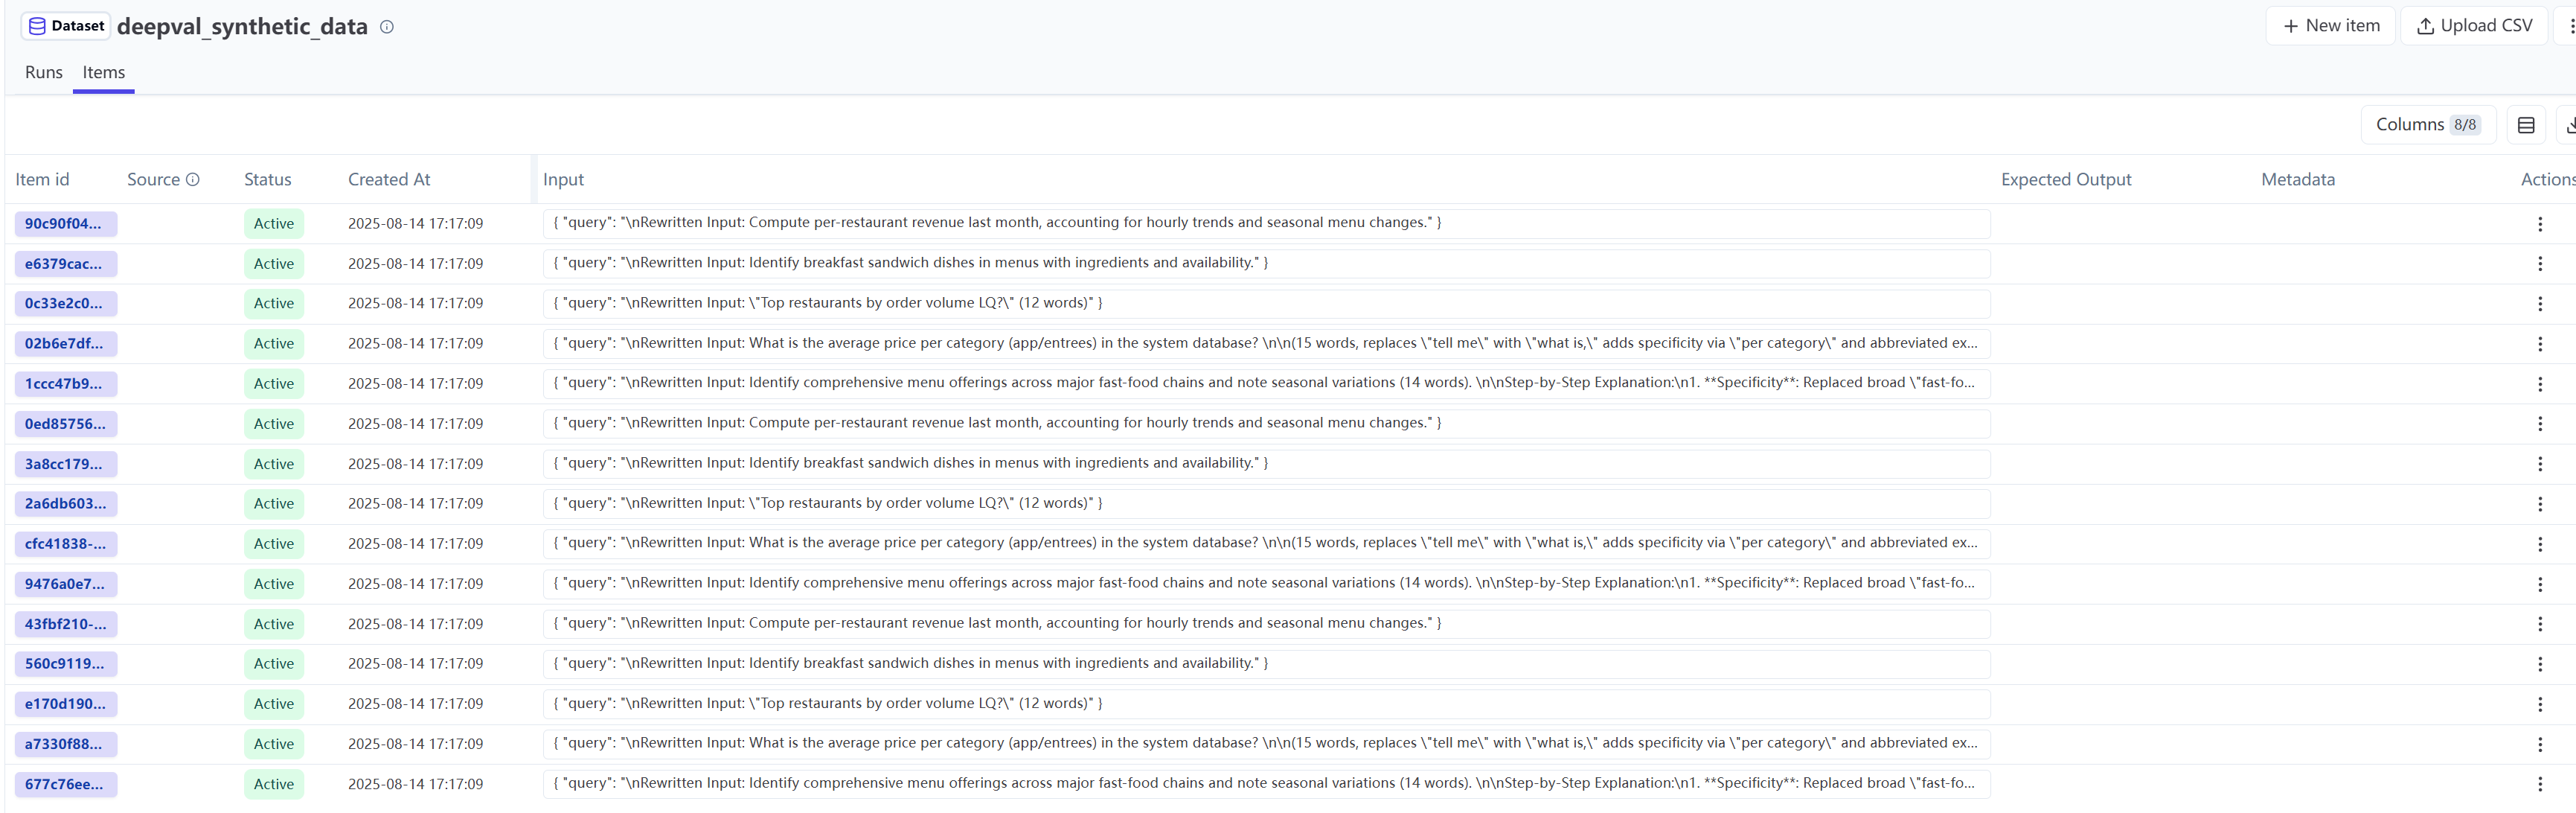

#### Example 4: No-Code via Hugging Face Dataset Generator

If you prefer a more UI-based approach, check out [Hugging Face’s Synthetic Data Generator](https://huggingface.co/blog/synthetic-data-generator). You can generate examples in the Hugging Face UI. Then you can download them as CSV and upload it in the Langfuse UI.